# Day 2: Preprocessing single-cell data and batch correction. TBC

# Goals

By the end of this tutorial you should be able to:

- analyse different single cell RNA sequencing (scRNA-seq) data objects;
- perform quality control and data normalisation;
- perform demensionality reduction (PCA, UMAP) and clustering;
- perform batch correction using Harmony;
- use automated cell type annotation; 
- clean the matrix using SoupX;
- prepare data for the use with different tools (CellphoneDB);

# Input dataset

Data produced in a single cell RNA-seq experiments gained popularity over its predicesor bulk RNA-seq due to its ability to measure heterogeniety of cells in the sample. Two characteristics that are important to keep in mind when working with scRNA-seq are drop-out (the excessive amount of zeros due to limited mRNA) and the potential of biology to be confounded by technical factors (e.g. batch, donor ect.). 

For this tutorial we will use scRNA-seq data from patients with severe Coronavirus disease 2019 (COVID-19),
the global pandemic caused by SARS-CoV-2 virus. The data includes a cell atlas of the bronchoalveolar lavage fluid immune cells from healthy and COVID19 patients published in Nature medicine (https://www.nature.com/articles/s41591-020-0901-9).

To reduce running time, we will use a subset of the atlas that includes a total of 60,382 cells from 2 healthy (H1- donor C51, H2- donor C52) and 2 COVID19 patients (S1- donor C143, S2 - donor C145). 

# Introduction 

In the previous session, you have learned how to generate matrix files from FASTQ files. In this session, we will begin by loading data, inspecting the count matrices and creating data object with counts, genes and metadata.

This session will also guide you to how to check the quality of your cells. This includes: checking the quality of the generated count data, preprecessing the data for analysis and visualising them by clustering. This is most basic workflow that you will run in any single-cell data analysis.

There are many packages, which have collection of functions for running this workflow. Such as Seurat, Scanpy, Monocle3. They offer streamlined workflow and tutorials that can be easily followed.

Today, we will use Seurat R package (http://satijalab.org/seurat/), a popular and powerful set of tools to conduct scRNA-seq analysis in R.

# 1. Different Single cell data objects
## 1.1 Load the relevant packages. 

You can check package versions using ```sessionInfo()``` for future reproducability of your results.

In [122]:
library(Seurat)
library(dplyr)
library(Matrix)
library(gdata)
library(DropletUtils)
library(patchwork)
library(harmony)

library(SoupX)
library(glmnet)

library(ggplot2)
library(ComplexHeatmap)

## 1.2 Read counts matrix

Typically the alignment tool (e.g. cellranger) output files include matrix.mtx, barcodes.tsv, genes.tsv files. These can be uploaded using ```Read10X()``` function in Seurat. Let's first load and examine the healthy donor run in our hc1 directory.

**Task**: Change the directory name to mydir/ where you saved your data

In [4]:
counts_matrix_filename = "/mnt/sc_train_course/covid19data/hc1/"
counts = Read10X(data.dir = counts_matrix_filename)  # Seurat function to read in 10x count data

## 1.3 Examine counts matrix

- How big is the matrix?

In [5]:
dim(counts) 

[1] 33538 11115

Here we see the counts matrix has 33538 genes (rows) and 11115 cells (columns).

- Why use sparse matrix vs dense matrix?

Storing the matrix in a dense format (where all count values including zeros are stored) takes almost 10 times as much memory than sparse matrix. This memory saving is very important, especially as data sets are now being created that are beyond a million cells. These matrices can become unmanageable without special computing resources.

In the sparse representation, we assume that the majority of count values in a matrix are zero. We only store the non-zero values. This is implemented in the Matrix package using a dgTMatrix object.

We can check the size of the sparve vs dense matrix using object.size() function. 

In [6]:
object.size(counts) # sparse matrix
object.size(as.matrix(counts)) # dense matrix

[1] 169189448 bytes

[1] 2985442408 bytes

## 1.4 Create & examine Seurat object

To analyze our single cell data we will use a seurat object. Can you create a Seurat object with the 10x data and save it in an object called ‘seurat’? hint: CreateSeuratObject(). 

In Seurat object, genes = Features and reads = Counts.

**Task**: Can you include only genes that are are expressed in 3 or more cells and cells with complexity of 350 genes or more? How many genes are you left with? How many cells?

In [7]:
seurat= CreateSeuratObject(
  counts,
  project = "SeuratProject",
  assay = "RNA",
  min.cells = 0,
  min.features = 0,
  names.field = 1,
  names.delim = "_",
  meta.data = NULL
)

The Seurat object contains various “slots” (designated by seurat@slotname) that will store the raw count data as well as the results from downstream computations. This has the advantage that we do not need to keep track of inidividual variables of interest - they can all be collapsed into a single object as long as these slots are pre-defined.

seurat@assays$RNA@counts is a slot that stores the original gene count matrix. You can expect other slots in the object using str(seurat) function.

## 1.5 Combine multiple data runs

You will most likely have multiple files from different experiments or sequencing runs that will need to be concatenated. Here we will load the remaining healthy and covid19 donors and create a single seurat object with all data. 

In [9]:
paths_healthy=c("/mnt/sc_train_course/covid19data/hc1", "/mnt/sc_train_course/covid19data/hc2/")
paths_disease=c("/mnt/sc_train_course/covid19data/S1/", "/mnt/sc_train_course/covid19data/S2")
names(paths_healthy)=c("HC1", "HC2")
names(paths_disease)=c("S1", "S2")

mtx_healthy=Read10X(paths_healthy)
mtx_disease=Read10X(paths_disease)

In [10]:
healthy_seurat=CreateSeuratObject(mtx_healthy)
disease_seurat=CreateSeuratObject(mtx_disease)

**Task**: We have two Seurat objects. How would you make one combined object? 

In [30]:
#Answer
combined_seurat=merge(healthy_seurat, disease_seurat)

**Task**: Inspect your Seurat object and report how many cells you have in each donor. 

In [31]:
#Answer
sum(combined_seurat@meta.data$orig.ident=='HC1')
sum(combined_seurat@meta.data$orig.ident=='HC2')
sum(combined_seurat@meta.data$orig.ident=='S1')
sum(combined_seurat@meta.data$orig.ident=='S2')

[1] 11115

[1] 10366

[1] 18044

[1] 20857

In [32]:
#Answer
combined_seurat@meta.data %>% group_by(orig.ident) %>% summarise(n=n()) %>% arrange(desc(n))

`summarise()` ungrouping output (override with `.groups` argument)



orig.ident n    
1 S2         20857
2 S1         18044
3 HC1        11115
4 HC2        10366

It is useful to know how to subsample your object, especially if you are working with huge cell atlases. 
We will subsample 10k cells from our object. 
Note: use set.seed() function to make sure that you select the same cells each time you run your code.  

In [33]:
set.seed(42)
samp1=sample(colnames(combined_seurat), 10000, replace = F)
combined_seurat=subset(combined_seurat, cells=samp1)

In [34]:
combined_seurat@meta.data %>% group_by(orig.ident) %>% summarise(n=n()) %>% arrange(desc(n))

`summarise()` ungrouping output (override with `.groups` argument)



orig.ident n   
1 S2         3496
2 S1         2933
3 HC1        1908
4 HC2        1663

# 2. Pre-process dataset for analysis 



## 2.1 Filtering low-quality cells

There are many steps that can go wrong in a scRNA-seq experiment. Your cells might have died before loading, which would yield low UMI counts from cells and higher background. Sometimes cell counting might have failed, resulting in over-loading. In this case, you may have high number of doublets. It's thus important to perform general QC for each run to filter out the outliers.

Additionally, we would like to exclude cells that are damaged or dying. A common metric to identify such cells is the relative expression of mitochondrially derived genes. When the cells apoptose, their mitochondrial RNA leaks into the cells. Thus a relative enrichment of mitochondrially derived genes can be a sign of cell stress. 

Let’s do some plotting to look at the number of expressed genes per cell (often called complexity), reads per cell and cell quality measure mitochondrial genes per cell.

 

Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: percent.mt”


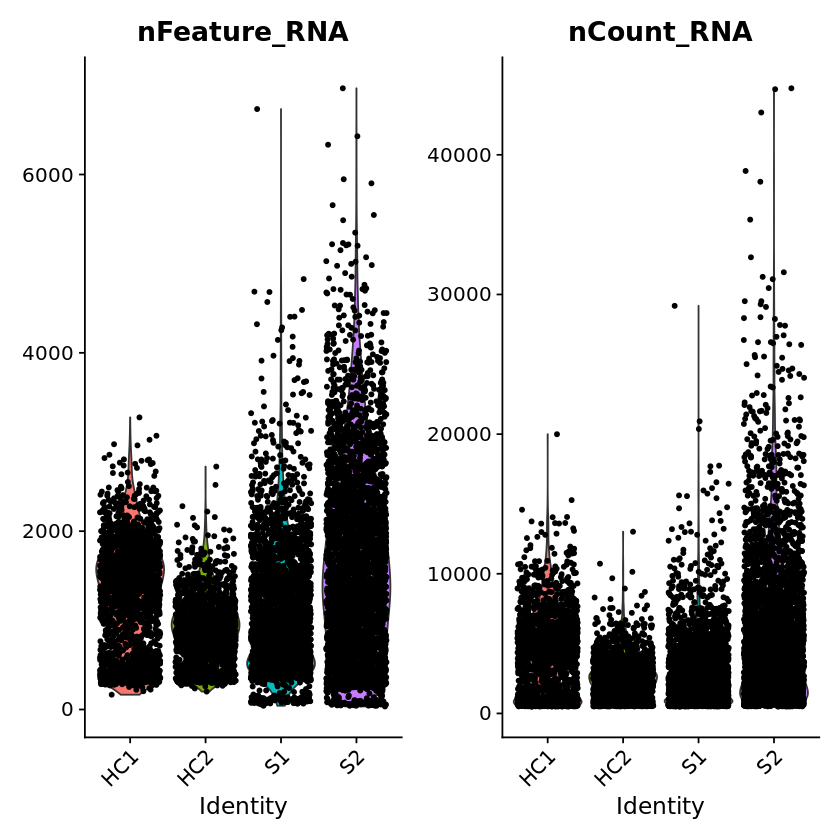

In [35]:
VlnPlot(combined_seurat, features = c("nFeature_RNA", "nCount_RNA","percent.mt"), ncol = 2)

**Task**: Have you noticed that the mitochondrial gene count is missing?
The number of genes and UMIs (nFeature_RNA and n_Count_RNA) are automatically calculated for every object by Seurat.  For non-UMI data, nUMI represents the sum of the non-normalized values within a cell. We calculate the percentage of mitochondrial genes here and store it as percent.mt. 

In [36]:
#Answer
combined_seurat[["percent.mt"]] <- PercentageFeatureSet(combined_seurat, pattern = "^MT-")

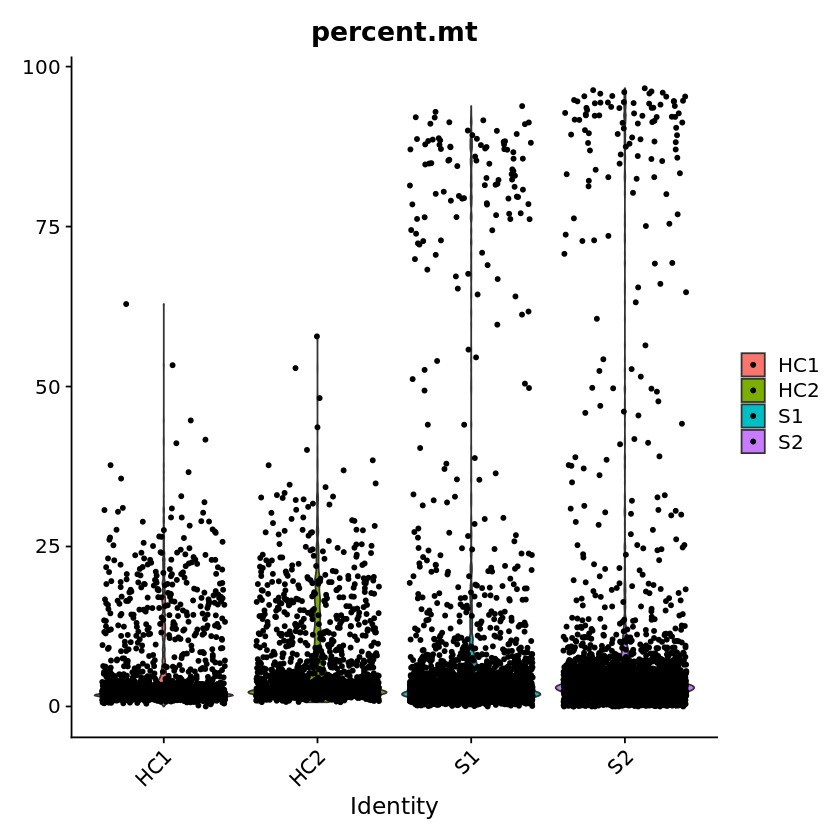

In [37]:
VlnPlot(combined_seurat, features = c("percent.mt"), ncol = 1)

There are cells in both COVID19 patients with over 75% mitochondrial RNA reads. These are likely dying/stressed cells. 

**Task**: Can you plot the relationship between nCount_RNA vs nFeature_RNA? What is the correlation? Do you see a some outliers? What do you think happened with these cells?

Can you plot the relationship between nCount_RNA vs percent_mt? What is the correlation? What filter would you use to filter out the dying cells? 

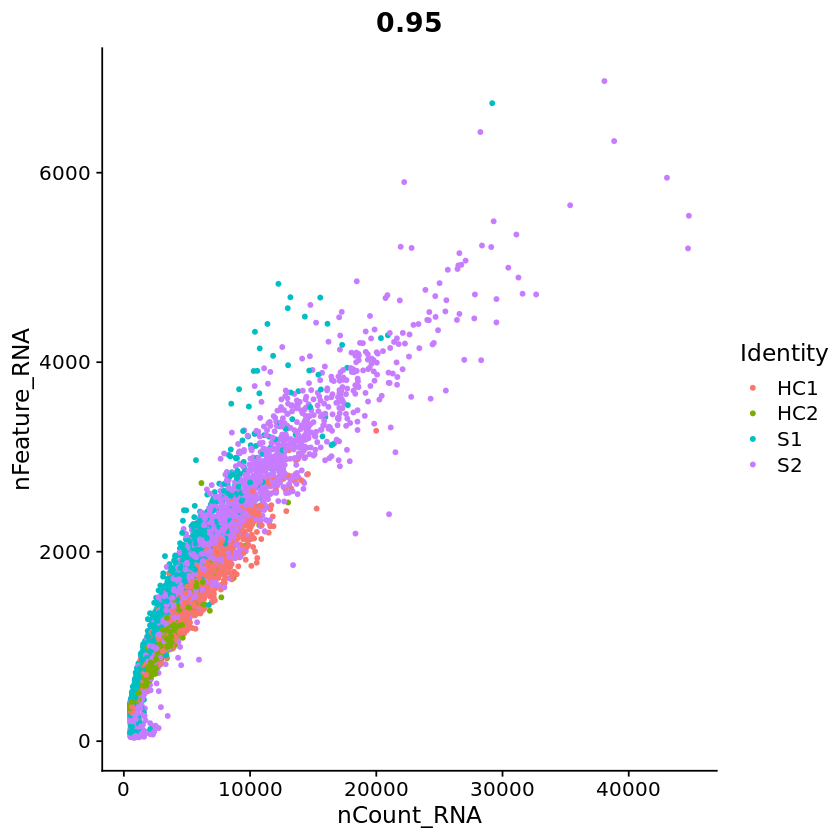

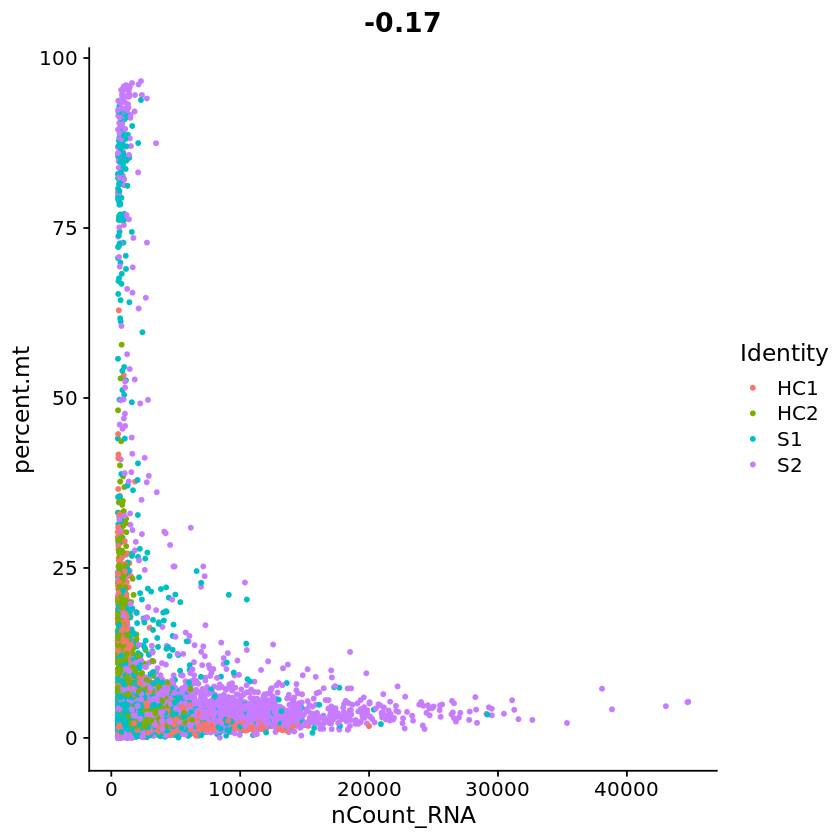

In [38]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 = FeatureScatter(combined_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot2 = FeatureScatter(combined_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")

plot1
plot2

Next, let’s filter the cells based on the quality control metrics. We will filter following the authors QC thresholds: 
1. nFeatures_RNA 200<x<6000
2. nCounts_RNA > 1000  
3. percent.mt 10%

**Task**: Change the thresholds to what you think they should be according to the violin plots.

In [39]:
combined_seurat = subset(combined_seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 6000 &nCount_RNA > 1000 & percent.mt < 10)

## 2.2 Expression normalization

After removing unwanted genes cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the gene expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

There have been many methods to normalize the data, but this is the simplest and the most intuitive. The division by total expression is done to change all expression counts to a relative measure, since experience has suggested that technical factors (e.g. capture rate, efficiency of reverse transcription) are largely responsible for the variation in the number of molecules per cell, although genuine biological factors (e.g. cell cycle stage, cell size) also play a smaller, but non-negligible role. 

In [40]:
combined_seurat = NormalizeData(object = combined_seurat, normalization.method = "LogNormalize", scale.factor = 1e4)

## 2.3 Finding highly variable genes

Currently there are over 30,000 captures genes in your matrix (n_vars). However, many of these genes are constitutively expressed across all cells (housekeeping genes, ribosomal protein mRNAs), which is not so informative to characterise cell type and function. Hence, it is very useful to select some genes that shows significant variation in your dataset (feature selection precess). This not only helps focusing your analysis onto more interesting variation, but also reduces dimensionality of your matrix, making it faster to run downstream processes!

Seurat calculates highly variable genes and focuses on these for downstream analysis. 

FindVariableGenes() calculates the average expression and dispersion for each gene, places these genes into bins, and then calculates a z-score for dispersion within each bin. This helps control for the relationship between variability and average expression.

We suggest that users set these parameters to mark visual outliers on the dispersion plot, but the exact parameter settings may vary based on the data type, heterogeneity in the sample, and normalization strategy. The parameters here identify ~2,000 variable genes, and represent typical parameter settings for UMI data that is normalized to a total of 1e4 molecules.

In [41]:
combined_seurat = FindVariableFeatures(combined_seurat, selection.method = "vst", nfeatures = 2000)

## 2.3 Data scaling

This part is where you mean center the data, substract the mean. You also divide by the standard deviation to make everything to a ‘standard normal’, where the mean is zero and the standard deviation is 1.

Whole object can be scaled prior to finding highly variable genes by specifying ```seurat=ScaleData(seurat, features = rownames(seurat))```. However, this leads to massively larger object size. 

In [42]:
combined_seurat = ScaleData(combined_seurat)

Centering and scaling data matrix



# 3. scRNA-seq data visualisation

## 3.1 Principal component analysis and clustering

Principal component analysis (PCA) is a dimensionality reduction technique used in single-cell RNA-seq data analysis. For each data point (cell) there are ~30k features (number of genes). In layman terms, PCA combines features in a way that explains the largest amount of variance in the data. By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset. You can select the number of PCs you’d like to calculate, but the default number is 50 (in Seurat).

In [43]:
combined_seurat = RunPCA(combined_seurat, npcs = 50, features=VariableFeatures(object = combined_seurat))

PC_ 1 
Positive:  LYZ, S100A9, CTSL, CTSB, S100A8, APOC1, MARCO, CD52, APOE, C1QB 
	   C1QA, MSR1, CTSZ, ACTB, FBP1, PLEK, CD14, PLIN2, FABP5, RETN 
	   C1QC, PLAUR, MCEMP1, TIMP1, CCL3, NCF1, FABP4, CALHM6, LILRB4, ARHGDIB 
Negative:  CD24, FXYD3, KRT8, KRT19, TSPAN1, MUC16, SMIM22, MUC4, ELF3, SLC44A4 
	   WFDC2, PERP, TACSTD2, KRT18, TMC5, CYP4B1, CLDN4, SLPI, PIGR, C19orf33 
	   LMO7, RSPH1, MAL2, C9orf24, CXCL17, FAM183A, CAPS, EPCAM, C1orf194, C20orf85 
PC_ 2 
Positive:  FABP4, APOC1, C1QA, NUPR1, APOE, C1QB, CRIP1, MARCO, RETN, GCHFR 
	   CD52, LYZ, RBP4, SCD, TFRC, MCEMP1, FBP1, CES1, VMO1, MSR1 
	   PDLIM1, TREM2, INHBA, C1QC, LDHB, STMN1, ATP1B1, AGRP, ALDH1A1, AC020656.1 
Negative:  ISG15, RSAD2, CCL2, ISG20, GBP1, IFIT3, TNFSF10, SAT1, IL1RN, VAMP5 
	   IFIT1, CCL3, CXCL10, IFIT2, APOBEC3A, MT2A, NFKBIA, SOD2, MT-ATP8, TYMP 
	   CCL8, ATP6V0C, ZFP36, CCL3L1, MAFB, C15orf48, NINJ1, GBP5, IDO1, WARS 
PC_ 3 
Positive:  GLUL, CSTB, CTSB, CTSL, S100A9, PLAUR, LYZ, S100A8, TIMP1,

Seurat provides a few ways to visualise features (and cells) that define principal components.

In [44]:
# examine the top 5 features that define first 5 principal components
print(combined_seurat[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  LYZ, S100A9, CTSL, CTSB, S100A8 
Negative:  CD24, FXYD3, KRT8, KRT19, TSPAN1 
PC_ 2 
Positive:  FABP4, APOC1, C1QA, NUPR1, APOE 
Negative:  ISG15, RSAD2, CCL2, ISG20, GBP1 
PC_ 3 
Positive:  GLUL, CSTB, CTSB, CTSL, S100A9 
Negative:  IL32, CD2, CD3E, PTPRCAP, GZMA 
PC_ 4 
Positive:  C9orf24, FAM183A, C20orf85, RSPH1, ROPN1L 
Negative:  GPRC5A, CEACAM6, S100A14, F3, KRT7 
PC_ 5 
Positive:  UBE2C, MKI67, TOP2A, BIRC5, TYMS 
Negative:  CD7, CCL5, PRF1, PTPRCAP, CST7 


**Task**: Now examine top 10 features in first 10 principal components.

In [45]:
#Answer:
print(combined_seurat[["pca"]], dims = 1:10, nfeatures = 10)

PC_ 1 
Positive:  LYZ, S100A9, CTSL, CTSB, S100A8, APOC1, MARCO, CD52, APOE, C1QB 
Negative:  CD24, FXYD3, KRT8, KRT19, TSPAN1, MUC16, SMIM22, MUC4, ELF3, SLC44A4 
PC_ 2 
Positive:  FABP4, APOC1, C1QA, NUPR1, APOE, C1QB, CRIP1, MARCO, RETN, GCHFR 
Negative:  ISG15, RSAD2, CCL2, ISG20, GBP1, IFIT3, TNFSF10, SAT1, IL1RN, VAMP5 
PC_ 3 
Positive:  GLUL, CSTB, CTSB, CTSL, S100A9, PLAUR, LYZ, S100A8, TIMP1, MAFB 
Negative:  IL32, CD2, CD3E, PTPRCAP, GZMA, LCK, CCL5, TYMS, CD7, TRBC2 
PC_ 4 
Positive:  C9orf24, FAM183A, C20orf85, RSPH1, ROPN1L, C1orf194, DYNLRB2, CAPSL, SNTN, C9orf116 
Negative:  GPRC5A, CEACAM6, S100A14, F3, KRT7, TM4SF1, ASS1, CEACAM5, S100A16, MET 
PC_ 5 
Positive:  UBE2C, MKI67, TOP2A, BIRC5, TYMS, CDK1, NUSAP1, CCNA2, GTSE1, ZWINT 
Negative:  CD7, CCL5, PRF1, PTPRCAP, CST7, CD2, CD3E, SPOCK2, NKG7, IL32 
PC_ 6 
Positive:  LGMN, RNASE1, FPR3, C1QC, NR1H3, FABP5, SPP1, LMNA, CCL18, NRP2 
Negative:  S100A9, S100A8, S100A12, FOLR3, FFAR2, HCAR3, G0S2, IDO1, FCN1, CCL3L1 
PC_

We can visualize principal components using DimPlot function. We can very clearly see that cells from healthy controls (HC) and Severe covid samples (S) segregate along PC1.

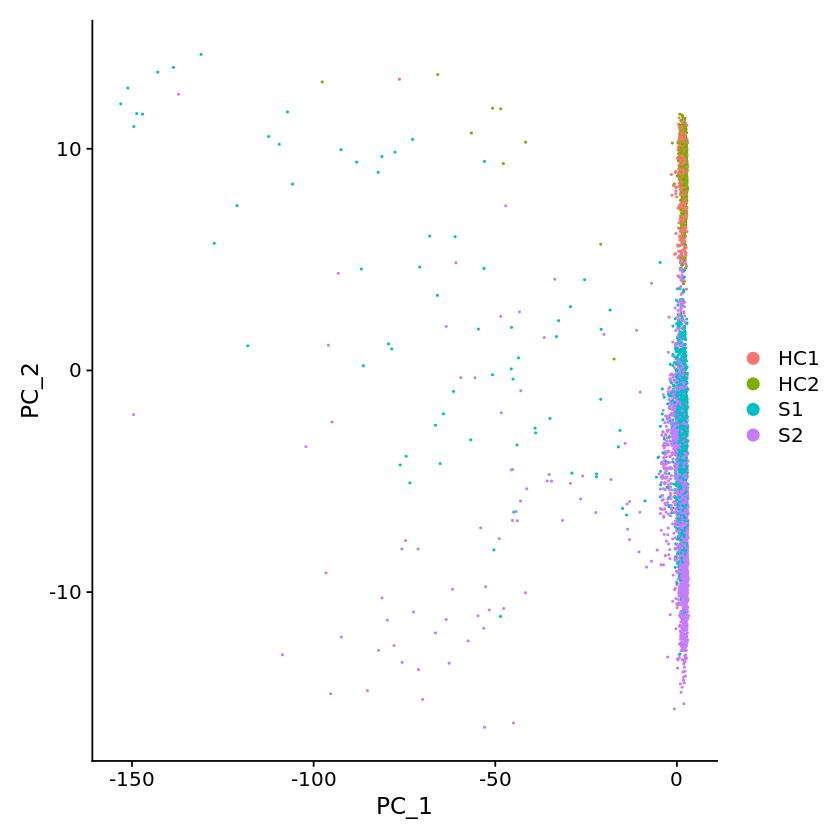

In [46]:
DimPlot(combined_seurat, reduction = "pca", dims = (c(1,2)))

**Task**: Plot PC3 and PC4.

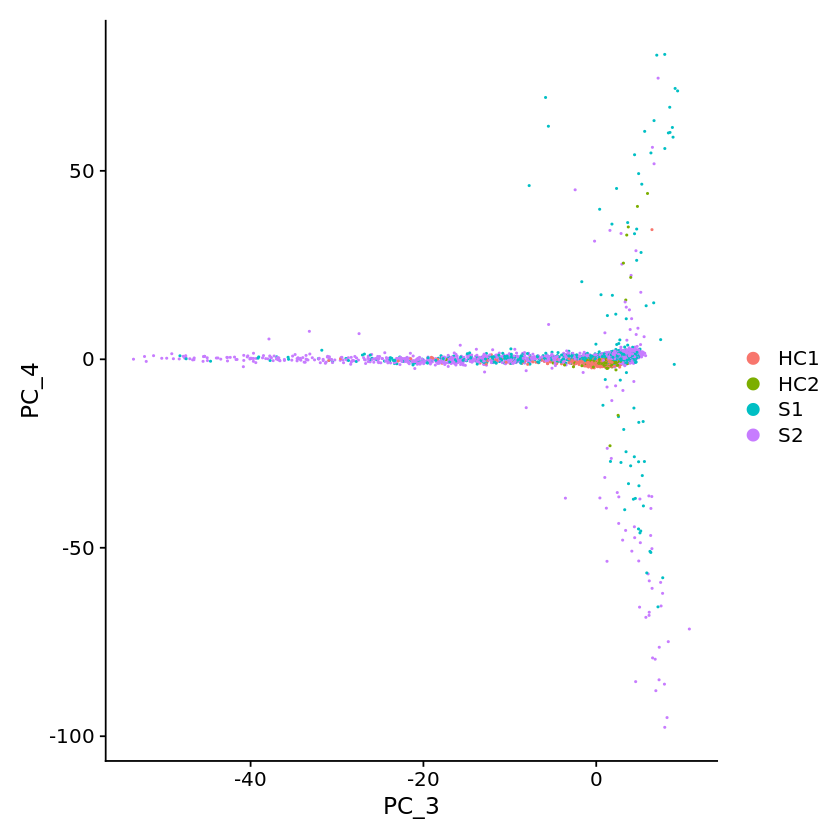

In [47]:
DimPlot(combined_seurat, reduction = "pca", dims = (c(3,4)))

In particular, DimHeatmap allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide how many PCs to include for downstream analyses. Both cells and features are ordered according to their PCA scores. Setting cells to a number plots the ‘extreme’ cells on both ends of the spectrum, which speeds up plotting for large datasets. It’s a valuable tool for exploring correlated feature sets.

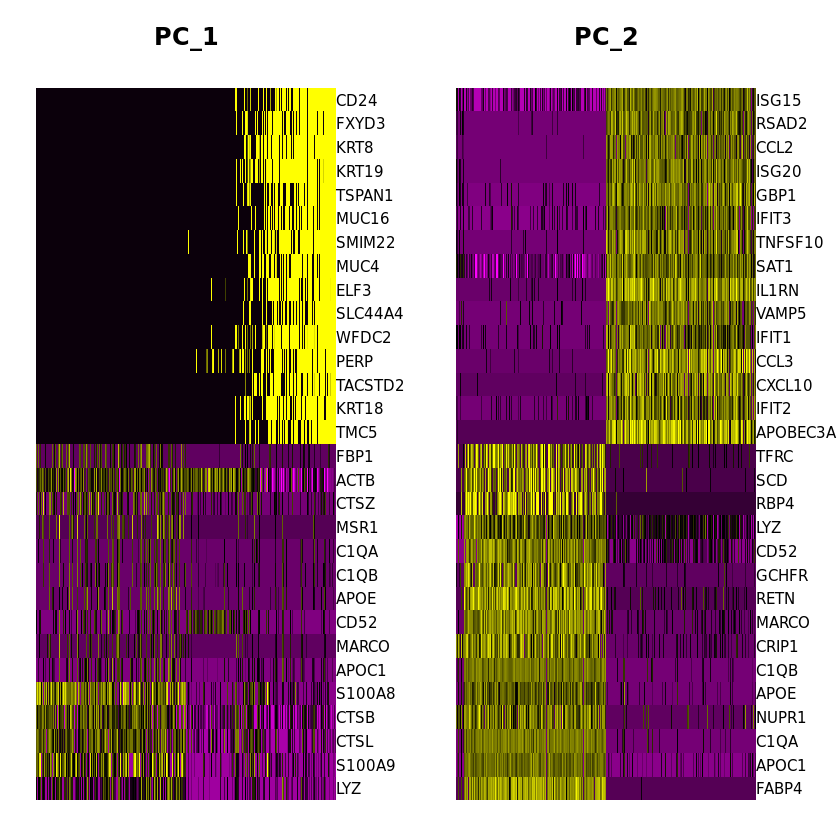

In [48]:
DimHeatmap(combined_seurat, dims = 1:2, cells = 500, balanced = TRUE)

**Task**: Have a look at the first 15 principal components.

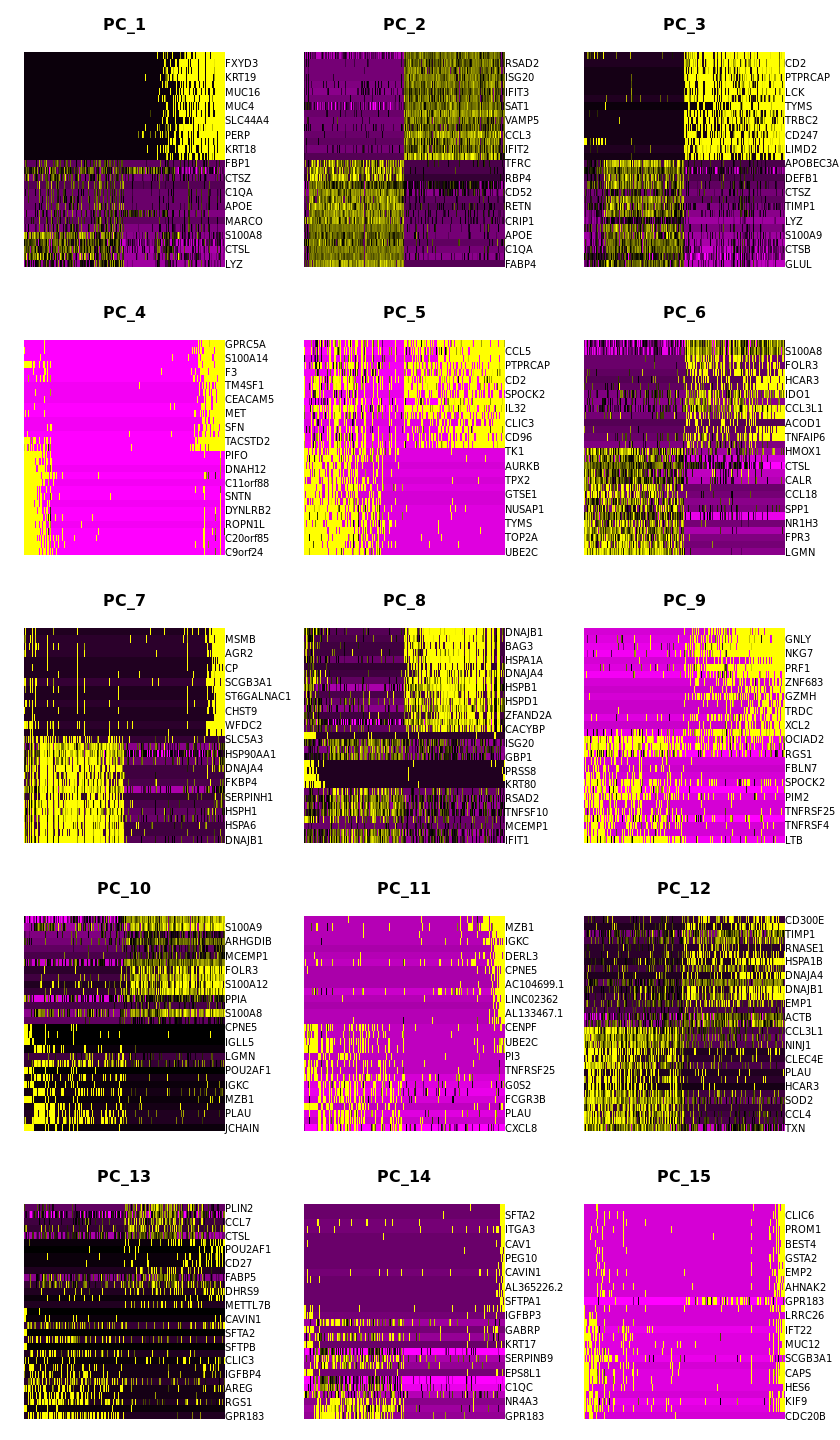

In [51]:
options(repr.plot.height = 12, repr.plot.width = 7)
DimHeatmap(combined_seurat, dims = 1:15, cells = 500, balanced = TRUE)

Downstream analysis will depend on the number of PCs you use - so what is the right number? The answer will depend on the dataset. There are a couple of functions implemented in seurat to determine the “optimal” number of PCs - the goal is to pick a number that explain the most variation, but reduce the noise in the data (and single cell data is very noisy).

The JackStraw function randomly permutes a subset of data, and calculates projected PCA scores for these ‘random’ genes. Then compares the PCA scores for the ‘random’ genes with the observed PCA scores to determine statistical signifance. End result is a p-value for each gene’s association with each principal component. We identify significant PCs as those who have a strong enrichment of low p-value genes. However, you still have to decide how many PCs are “significant”. This is hard when the dimensionality of your dataset is high.

**WARNING**: this takes a few minutes, so only run it yourself if you have enough time.

In [52]:
combined_seurat = JackStraw(combined_seurat, num.replicate = 100)
combined_seurat = ScoreJackStraw(combined_seurat, dims = 1:20)

Warning message:
“Removed 28000 rows containing missing values (geom_point).”


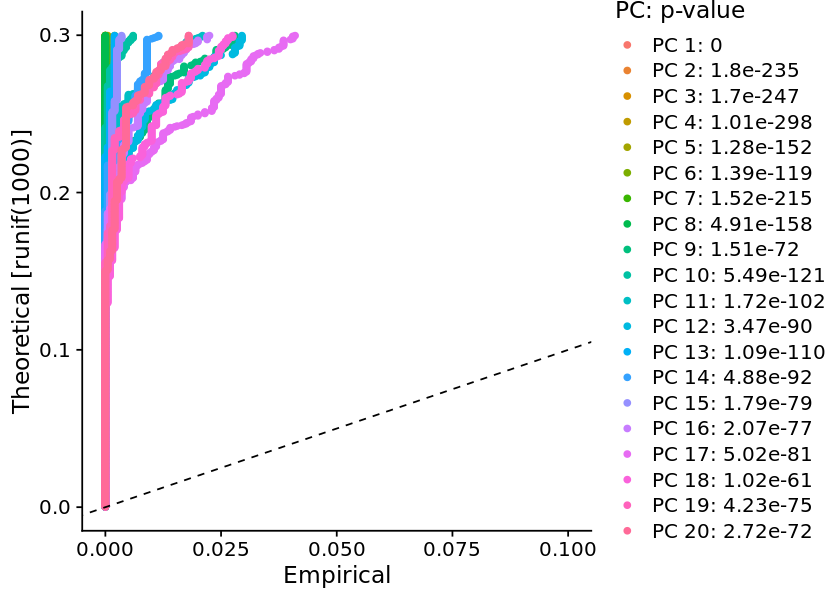

In [54]:
options(repr.plot.height = 5, repr.plot.width = 7)
JackStrawPlot(combined_seurat, dims = 1:20)

As you can see in the plot, the first 20 PCs all have a strong enrichment in low p-value genes - so the dimensionality of our dataset is higher than 20PCs. The next step would be to run jackstraw for higher number of PCs (eg. 40).

There are some alternative methods out there, such as molecular cross-validation (MCV). MCV randomly apportions the counts from each cell into two groups, each simulating a shallower, but statistically independent measurement of the original cell. The accuracy of PCA can be evaluated by fitting it on one of the groups (training) and comparing the PCA output to the other group (validation). It is a bit similar to Jackstaw in that it downsamples the data, but does so within each cell. This method outputs the optimal number of PCs to use.

**WARNING**: Please don’t run this on your virtual machine as it will take a few hours. The code is included and you can run it in your own time. For the purposes of this practical, it is already has been run and the number of PCs this algorithm suggests is 30.

In [ ]:
#DON'T RUN THIS CODE
source('https://raw.githubusercontent.com/constantAmateur/MCVR/master/code.R')
# define a function that does standard processing that is required by the molecularCrossValidation function.
stdProcess = function(dat,...){
  ss = CreateSeuratObject(dat)
  ss = NormalizeData(ss,verbose=FALSE)
  ss = ScaleData(ss,verbose=FALSE,...)
  return(ss@assays$RNA@scale.data)
}
#run the function
mcv = molecularCrossValidation(roundToInt(combined_seurat@assays$RNA@counts),VariableFeatures(combined_seurat),normalisation=stdProcess,features=VariableFeatures(combined_seurat),tFracs=c(1,0.9,0.8,0.5),nSplits=5)
#get the optimal number of PCs
max(mcv$mins1sd[[1]])

Although we have now reduced 30k features to 30 PCs, we still can’t properly visualise that. Therefore, we run **UMAP (Uniform Manifold Approximation and Projection)**, which is a non-linear dimensionality reduction technique (unlike PCA, which is linear) to visualise our data in two dimensions. First, however, we need to compute a k-nearest neighbour graph, which will take the dimensionality of the dataset (as we have already defined) as an input. 

We can also cluster the cells at this point, so that cluster identities are in place when we actually produce our UMAP. Seurat uses Louvain algorithm by default, but SNM and Leiden (requires python) algorithms are also available. An alternative to UMAP is **tSNE (t-stochastic neighbour embedding)**.

In [73]:
combined_seurat = FindNeighbors(combined_seurat, dims = 1:30)
combined_seurat = FindClusters(combined_seurat, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7583
Number of edges: 303410

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8507
Number of communities: 13
Elapsed time: 0 seconds


We can now run our UMAP, which, again, takes the dimensionality of the dataset as an input.

You can also change parameters, such as k-nearest neighbors and distance.

Task: Find out what the parameters above are, and how to change them. Hint: to find out about a function in R and its inputs, run a "?function in your console. For RunUMAP, this will be ?RunUMAP.

In [60]:
?runUMAP
#n_neighbors: This determines the number of neighboring points used in local approximations of manifold structure. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50.
#min_dist: This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5.

We will run default parameters:

In [74]:
combined_seurat = RunUMAP(combined_seurat, dims = 1:30)

18:35:43 UMAP embedding parameters a = 0.9922 b = 1.112

18:35:43 Read 7583 rows and found 30 numeric columns

18:35:43 Using Annoy for neighbor search, n_neighbors = 30

18:35:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

18:35:45 Writing NN index file to temp file /tmp/Rtmp8szWQL/file1b902ae16aa0

18:35:45 Searching Annoy index using 1 thread, search_k = 3000

18:35:47 Annoy recall = 100%

18:35:48 Commencing smooth kNN distance calibration using 1 thread

18:35:50 Initializing from normalized Laplacian + noise

18:35:50 Commencing optimization for 500 epochs, with 330394 positive edges

18:35:59 Optimization finished



Let’s visualize:

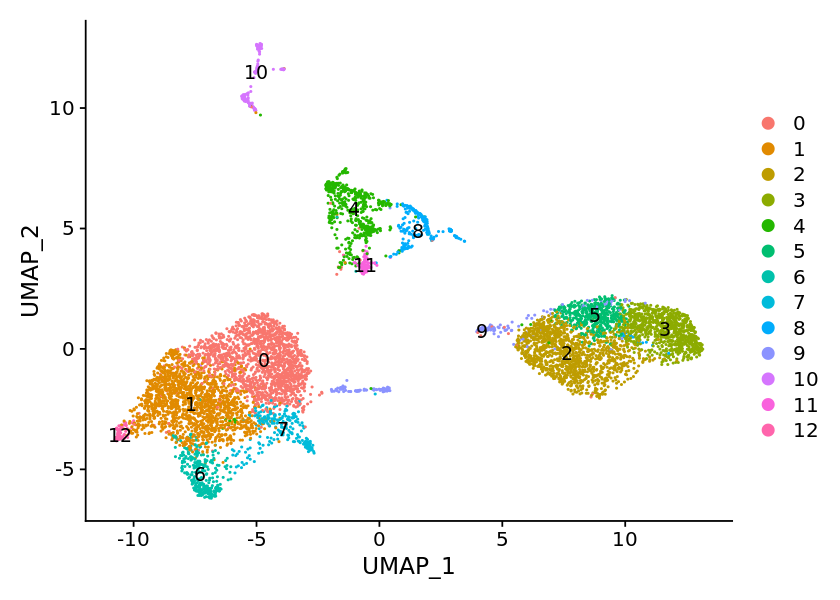

In [75]:
DimPlot(combined_seurat, label=T)

**Task**: Try re-running (and re-plotting) the UMAP with various min_dist and n_neighbours parameters. Don’t forget to re-run the default afer you’re done exploring!

**Task**: Run a tSNE with the same number of PCs as the UMAP.

## 3.2 Gene signature scoring

Sometimes we want to ask what is the expression of a set of a genes across cells. This set of genes may make up a gene expression program we are interested in. Another benefit at looking at gene sets is it reduces the effects of drop outs.

Below, we look at genes involved in the cell cycle. First, we assign each cell a score, based on its expression of G2/M and S phase markers. These marker sets should be anticorrelated in their expression levels, and cells expressing neither are likely not cycling and are in G1 phase.

We assign scores in the CellCycleScoring function, which stores S and G2/M scores in object meta data, along with the predicted classification of each cell in either G2M, S or G1 phase. CellCycleScoring can also set the identity of the Seurat object to the cell-cycle phase by passing set.ident = TRUE (the original identities are stored as old.ident). Please note that Seurat does not use the discrete classifications (G2M/G1/S) in downstream cell cycle regression. Instead, it uses the quantitative scores for G2M and S phase. However, we provide our predicted classifications in case they are of interest.

In [76]:
# Read in a list of cell cycle markers, from Tirosh et al, 2015.
# We can segregate this list into markers of G2/M phase and markers of S phase.
cc.genes = readLines("/mnt/sc_train_course/regev_lab_cell_cycle_genes.txt")
s.genes = cc.genes[1:43]
g2m.genes = cc.genes[44:97]

combined_seurat <- CellCycleScoring(combined_seurat, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”


**Task**: Plot UMAP and color the cell cycle phase. Where do we store the cell cycle phase information in the Seurat object?

orig.ident nCount_RNA nFeature_RNA percent.mt
S2_GTAGTCAGTGTCCTCT-1  S2         3263       1187         1.961385  
S1_GGGTTGCAGACACGAC-1  S1         2929       1137         3.209286  
HC1_TACGGATTCCTAGGGC-1 HC1        6230       1737         2.199037  
S2_CCAGCGACATGGTCTA-1  S2         3913       1136         2.632251  
S2_CCTTTCTAGCTTATCG-1  S2         1281        520         7.806401  
HC2_GACACGCGTCCAAGTT-1 HC2        1603        584         2.495321  
                       RNA_snn_res.0.6 seurat_clusters S.Score     G2M.Score  
S2_GTAGTCAGTGTCCTCT-1  4               4                0.16105104  0.01548968
S1_GGGTTGCAGACACGAC-1  0               0                0.03633595 -0.02856456
HC1_TACGGATTCCTAGGGC-1 3               3               -0.03170845  0.02411881
S2_CCAGCGACATGGTCTA-1  6               6               -0.04012553 -0.06048113
S2_CCTTTCTAGCTTATCG-1  12              12              -0.02176851  0.01681725
HC2_GACACGCGTCCAAGTT-1 2               2                0.01404000 -0.04421464
                       Phase old.ident
S2_GTAGTCAGTGTCCTCT-1  S     4        
S1_GGGTTGCAGACACGAC-1  S     0        
HC1_TACGGATTCCTAGGGC-1 G2M   3        
S2_CCAGCGACATGGTCTA-1  G1    6        
S2_CCTTTCTAGCTTATCG-1  G2M   12       
HC2_GACACGCGTCCAAGTT-1 S     2

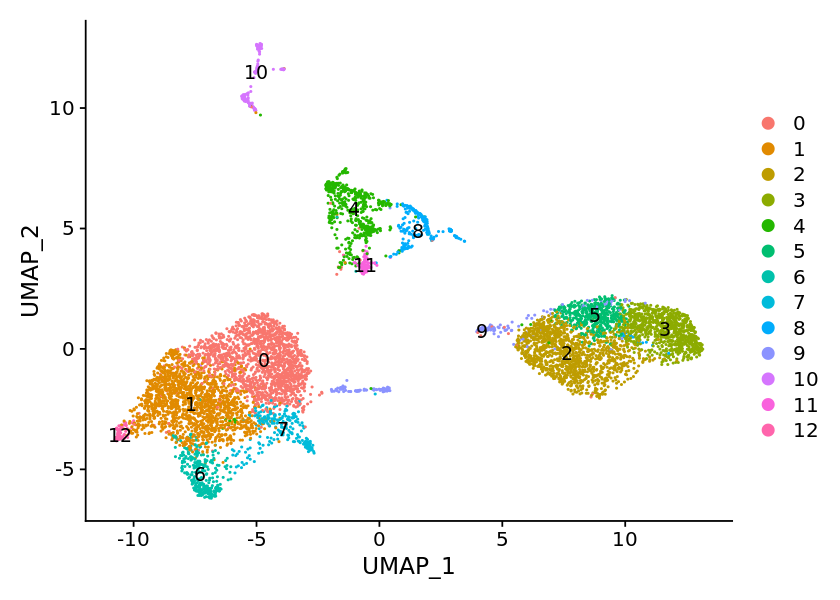

In [77]:
head(combined_seurat[[]])

DimPlot(combined_seurat, label=T)

We can see that cluster 8 are predicted to be in G2M/S phase and are cycling. 

# 4. Annotation

At this point in your analysis, you’ll probably want to annotate your cells. This can be a task of varying difficulty - annotating PBMCs, for example, might be straightforward given the wealth of single-cell PBMC data out there already. If you have a completely novel dataset, you might have to rely on a small number of studies for marker genes. 

We will try two different kinds of annotation - manual (marker-based) and automated annotation, which relies on the the whole transcriptome of a reference dataset (or markers picked in an unbiased way).

## 4.1 Manual annotation

Manual annotation is the standard way of annotating data. We begin by finding cluster markers - there are a number of functions to do this, but today we will use FindAllMarkers() in Seurat and quickMarkers() in SoupX.

Seurat can help you find markers that define clusters via differential expression. The min.pct argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can do this for one cluster, where it compares that cluster to everything else:

In [78]:
cluster1.markers = FindMarkers(combined_seurat,ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

p_val avg_logFC pct.1 pct.2 p_val_adj
APOBEC3A 0     1.626882  0.916 0.286 0        
IL1RN    0     1.533435  0.965 0.407 0        
CCL2     0     1.515645  0.973 0.462 0        
S100A12  0     1.489916  0.490 0.085 0        
CXCL10   0     1.465734  0.913 0.384 0

But you can also do this for all clusters:

In [79]:
#only pos = TRUE - only positive markers; we also select a log fc threshold. Print only top 2 markers for each cluster.
all.markers = FindAllMarkers(combined_seurat, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
all.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



p_val         avg_logFC pct.1 pct.2 p_val_adj     cluster gene    
1   0.000000e+00 1.884419  0.611 0.114  0.000000e+00 0       RNASE1  
2  6.134826e-299 1.651674  0.656 0.215 2.057559e-294 0       SPP1    
3   0.000000e+00 1.626882  0.916 0.286  0.000000e+00 1       APOBEC3A
4  2.431730e-265 1.583099  0.784 0.341 8.155780e-261 1       CCL8    
5   0.000000e+00 1.819005  0.998 0.781  0.000000e+00 2       LYZ     
6   0.000000e+00 1.691615  0.998 0.487  0.000000e+00 2       APOE    
7   0.000000e+00 1.718951  0.987 0.486  0.000000e+00 3       CRIP1   
8   0.000000e+00 1.595641  0.973 0.309  0.000000e+00 3       MCEMP1  
9   0.000000e+00 2.363299  0.860 0.088  0.000000e+00 4       IL32    
10 8.205064e-301 2.251585  0.607 0.083 2.751896e-296 4       CCL5    
11 1.854171e-238 1.511010  0.980 0.362 6.218703e-234 5       RETN    
12 1.101405e-194 1.238601  0.726 0.179 3.694003e-190 5       INHBA   
13  0.000000e+00 3.579664  0.830 0.104  0.000000e+00 6       HSPA6   
14 4.483056e-254 3.080935  0.937 0.232 1.503572e-249 6       DNAJB1  
15 1.453743e-117 2.372415  0.792 0.236 4.875709e-113 7       CCL18   
16 3.788359e-110 1.269113  0.933 0.307 1.270578e-105 7       LGMN    
17 1.257090e-140 2.526092  0.919 0.290 4.216155e-136 8       HIST1H4C
18  6.539641e-89 2.171457  0.357 0.045  2.193330e-84 8       GNLY    
19 1.409487e-166 3.186736  0.251 0.009 4.727279e-162 9       JCHAIN  
20  1.872004e-19 1.052735  0.251 0.082  6.278515e-15 9       CST7    
21  0.000000e+00 4.300275  0.904 0.061  0.000000e+00 10      SLPI    
22 3.724427e-167 4.530326  0.589 0.052 1.249135e-162 10      SCGB3A1 
23 2.507199e-276 3.478196  0.935 0.054 8.408896e-272 11      GZMB    
24 4.673087e-264 3.876297  0.839 0.044 1.567307e-259 11      GNLY    
25 7.621552e-169 3.401188  0.905 0.075 2.556192e-164 12      HCAR3   
26 1.029441e-106 3.545601  0.459 0.027 3.452641e-102 12      PI3

It’s also possible to compare specific populations, which is quite useful down the line if you want to look at differentially expressed genes between different cell types:

In [80]:
#compare cluster 5 to clusters 0 and 3
cluster5.markers = FindMarkers(combined_seurat, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

p_val         avg_logFC pct.1 pct.2 p_val_adj    
HP    2.581266e-227 1.1985157 0.452 0.012 8.657307e-223
LYZ   4.983719e-205 1.5332581 0.998 0.865 1.671490e-200
RPL21 2.991628e-194 1.2470351 0.998 0.824 1.003362e-189
RPL17 1.865958e-190 1.3692174 0.987 0.604 6.258237e-186
RPS27 9.899847e-183 0.9677208 1.000 0.943 3.320310e-178

SoupX’s quickMarkers uses tf-idf, an algorithm used in text analysis, to find cluster markers. It takes the count matrix as an input, and by default outputs top 10 positive markers (to output more markers, change the N parameter)

One really useful feature of quickMarkers is that it also calculates the frequency of that gene (e.g % of cells expressing that gene) in the second highest cluster, which can shed the light on which clusters might be similar (or, indeed, the same cell type). Have a look at frequencies of cluster 0’s marker genes in other clusters - which clusters are they? Does it make sense, given what the UMAP looks like?

In [84]:
qm_all = quickMarkers(combined_seurat@assays$RNA@counts, combined_seurat@meta.data$seurat_clusters, N = 10)
head(qm_all)

gene   cluster geneFrequency geneFrequencyOutsideCluster
1 RNASE1 0       0.6108735     0.1136899                  
2 LGMN   0       0.7067807     0.2218298                  
3 FPR3   0       0.6053757     0.1791120                  
4 SDS    0       0.5632254     0.1659939                  
5 SPP1   0       0.6560782     0.2151026                  
6 EMP1   0       0.6701283     0.2603431                  
  geneFrequencySecondBest geneFrequencyGlobal secondBestClusterName tfidf    
1 0.5250000               0.2210207           7                     0.9221129
2 0.9333333               0.3265198           7                     0.7910746
3 0.7625000               0.2711328           7                     0.7901040
4 0.5666667               0.2517473           7                     0.7768733
5 0.6208333               0.3102994           7                     0.7677544
6 0.6541667               0.3488065           7                     0.7058045
  idf      qval         
1 1.509499  0.000000e+00
2 1.119265 9.154448e-282
3 1.305147 1.869319e-232
4 1.379329 3.853940e-209
5 1.170218 4.062736e-236
6 1.053238 5.167036e-197

Most of the time, when annotating a dataset, you will already have some ideas about what kind of cell types you might expect. For example, we know that our dataset will mostly contain immune cells- so it makes sense to have a look at some widely-known immune markers in addition to cluster-defining genes. Let’s have a look at expression of CD45 (gene symbol PTPRC), which is expressed in all differentiated hematopoietic cells (except erythrocytes and plasma cells). We can also check EPCAM- marker ubiquitously expressed in epithelial cells.

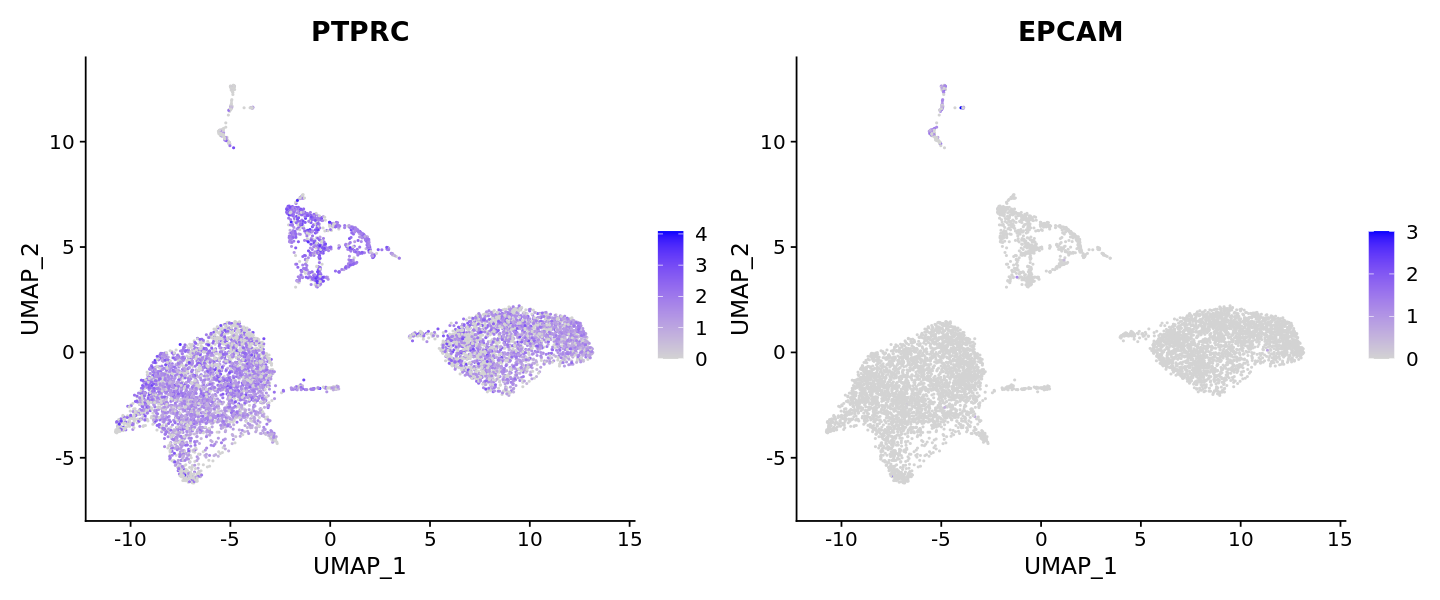

In [88]:
options(repr.plot.height = 5, repr.plot.width = 12)
FeaturePlot(combined_seurat, c("PTPRC","EPCAM"))

It’s clear that we mostly have immune cells in this dataset, with the exception of epithelial cluster at the top (cluster 10). Now let’s have a look at some macrophage-specific markers (I googled them - and you’ll be doing a lot of that too):

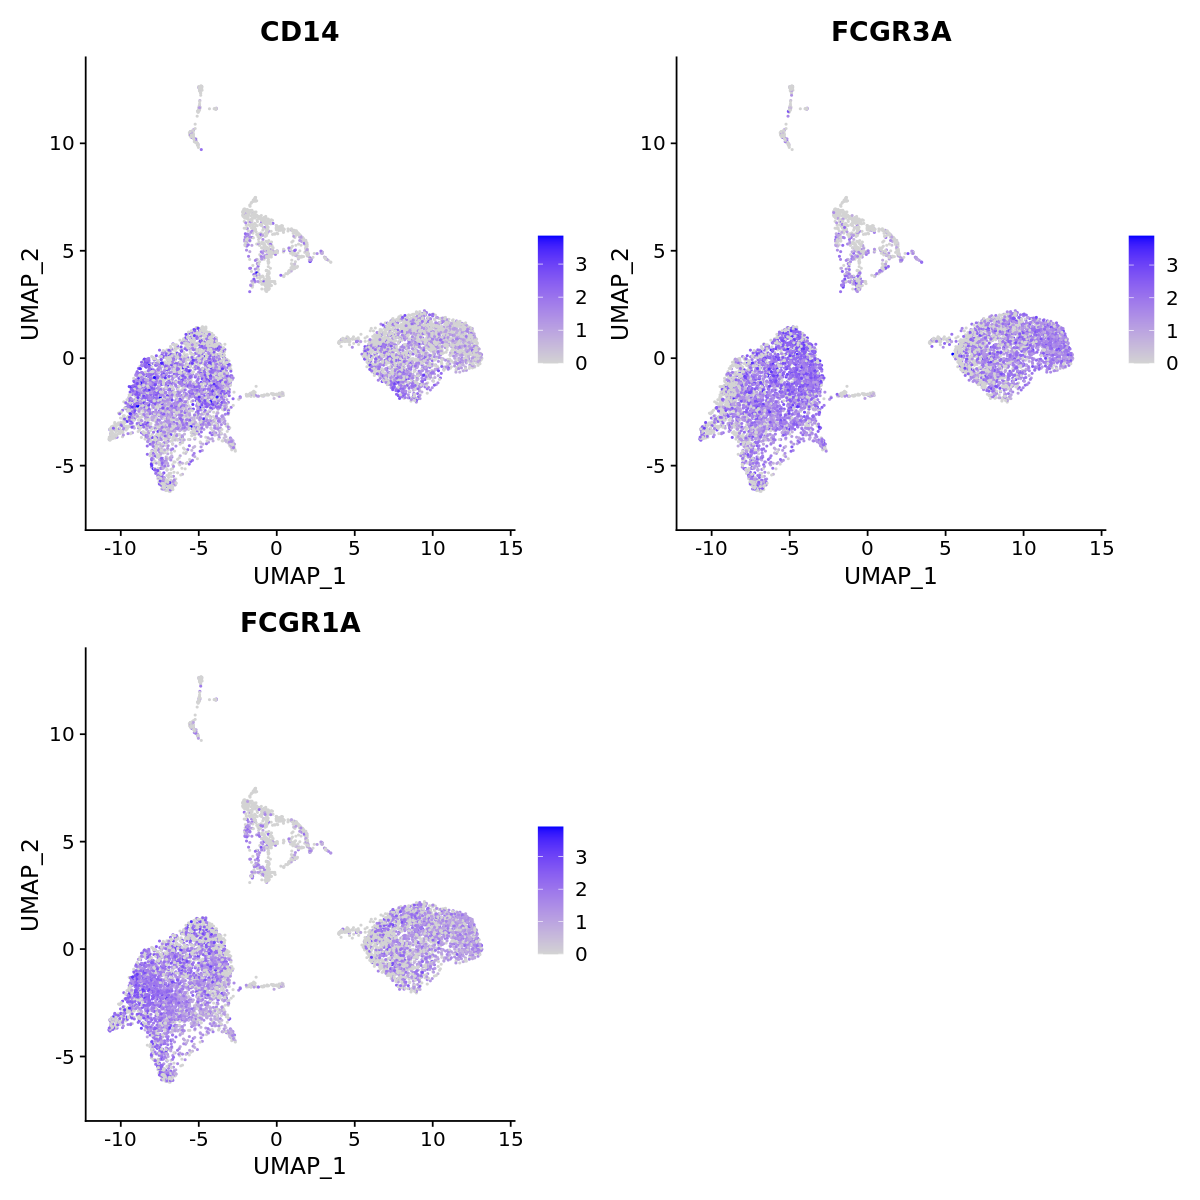

In [93]:
options(repr.plot.height = 10, repr.plot.width = 10)
FeaturePlot(combined_seurat, c("CD14", "FCGR3A", "FCGR1A"))

Let’s visualise these markers per-cluster using VlnPlot (shows expression probability distributions across clusters).



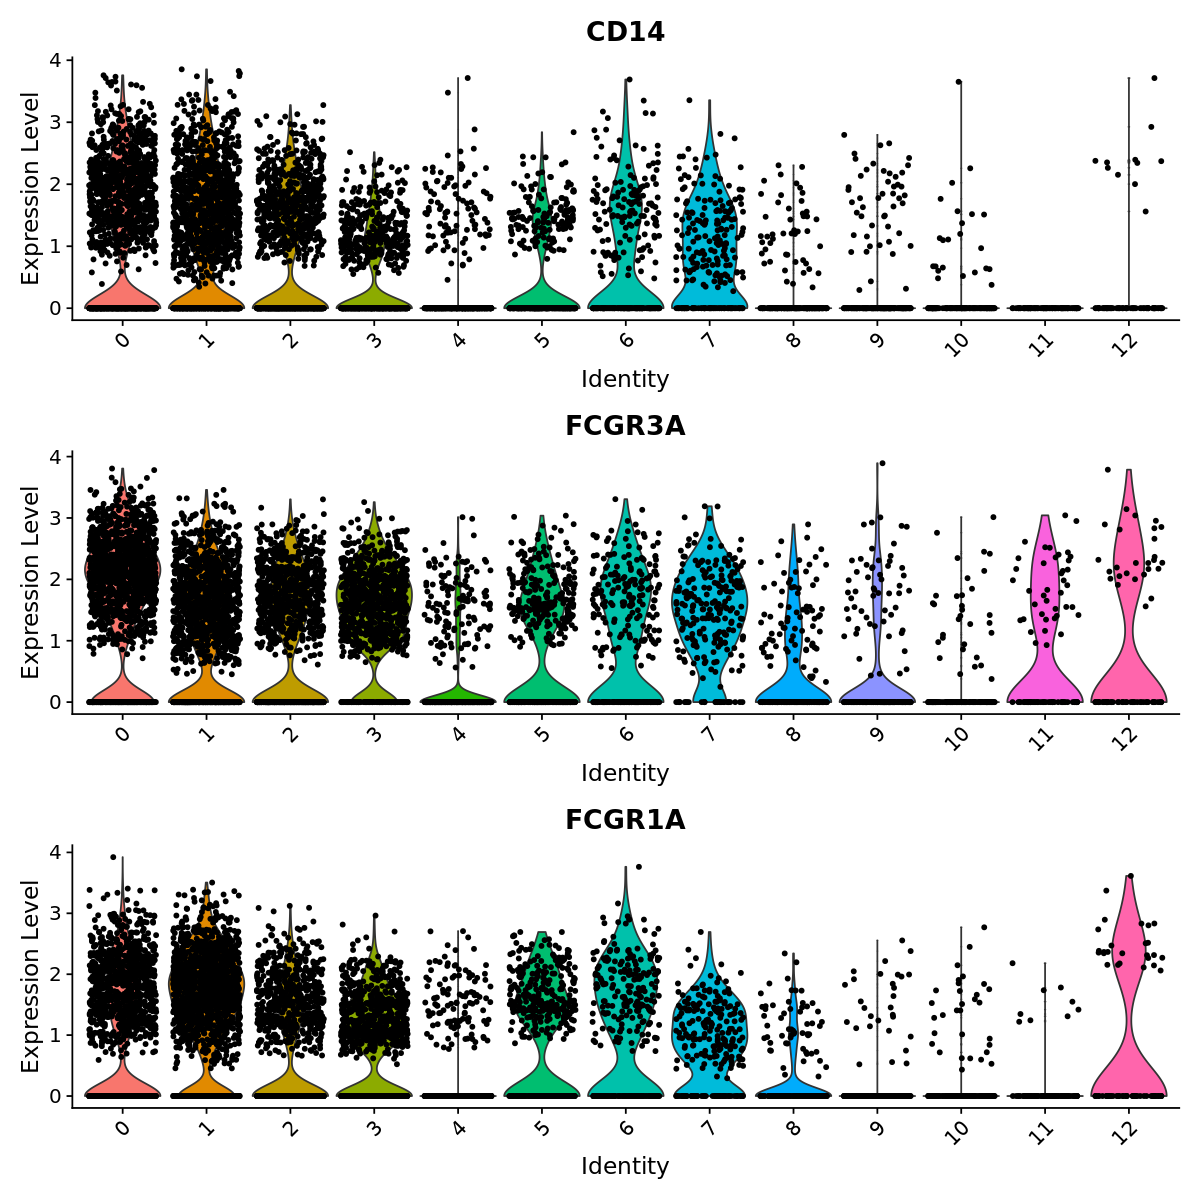

In [92]:
VlnPlot(combined_seurat, c("CD14","FCGR3A","FCGR1A"), ncol=1)

It’s very clear that based on CD14, clusters 0,1,2,3,5,6,7 are macrophages. Some of the other clusters express FCGR3A and FCGR1A, but it’s possible for these markers to be expressed in other immune compartments. However, if you look for any of the above genes in the marker lists from FindAllMarkers and QuickMarkers, you will not find them (or if you do, they won’t be at the top of the list). That’s because algorhitmic marker discovery relies on what’s different between each cluster and the rest of the dataset - and in this instance, there’s no difference between, for example, cluster 0 and the vast majority of the rest of the dataset.

What about cluster 12? Most cells in that cluster don’t express CD14, as can be seen by the probability density, but they do express FCGR3A and FCGR1A. This is where algorithmic markers might come in handy - let’s see what the markers of cluster 12 are:

In [94]:
head(qm_all[qm_all$cluster==12,])

gene   cluster geneFrequency geneFrequencyOutsideCluster
121 HCAR3  12      0.9054054     0.07510987                 
122 FCGR3B 12      0.8243243     0.08989213                 
123 G0S2   12      0.8378378     0.11586097                 
124 HCAR2  12      0.7162162     0.09748302                 
125 PLAU   12      0.7702703     0.11879078                 
126 PI3    12      0.4594595     0.02650153                 
    geneFrequencySecondBest geneFrequencyGlobal secondBestClusterName tfidf   
121 0.1416667               0.08321245          7                     2.251162
122 0.1889313               0.09705921          1                     1.922682
123 0.3833333               0.12290650          6                     1.756386
124 0.2857143               0.10352103          3                     1.624364
125 0.3541667               0.12514836          7                     1.600818
126 0.1164384               0.03072663          10                    1.600125
    idf      qval        
121 2.486358 5.604318e-61
122 2.332434 8.427693e-46
123 2.096331 3.315506e-41
124 2.267980 1.538544e-32
125 2.078255 1.856756e-33
126 3.482626 8.739713e-29

Googling HCAR3 doesn’t give many clues, but having a look at FCGR3B in Protein atlas shows that it’s highly expressed in neutrophils! Googling “FCGR3B neutrophil” returns a couple of results suggesting that FCGR3B is a neutrophil marker - so cluster 12 are probably neutrophils. It is important to note, that you will likely need to see co-expression of more than one gene to confidently assign  cell identity. 

It’s really important that you plot some high-level markers in your data so that you know what you’re working with before getting into the nitty gritty of it. How deeply you want to annotate your data will depend on what you’re trying to achieve. Now that we know that clusters 0,1,2,3,5,6,7 are macrophages, we could try identify macrophage subtypes within the data (you could do this in your own time).

**Task**: Have a go at annotating the remaining clusters by looking at markers of those clusters.

**Task**: Plot UMAP and color donor information ("orig.ident"). Macrophages cluster separately. Do you think there is a "batch effect" in this data?

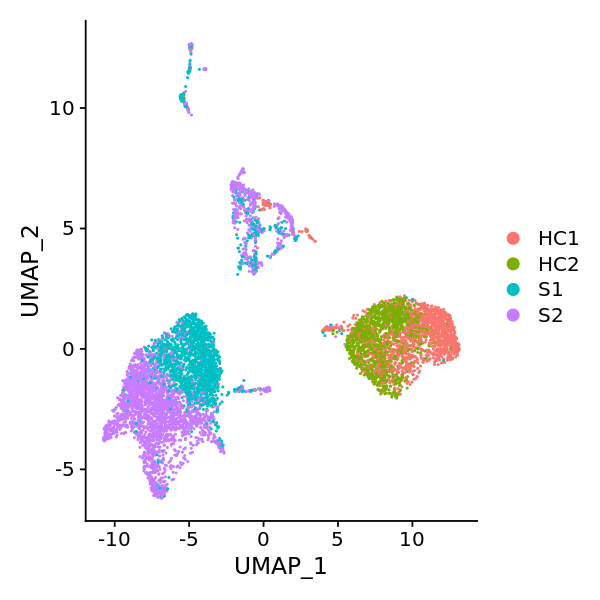

In [96]:
options(repr.plot.height = 5, repr.plot.width = 5)
DimPlot(combined_seurat, reduction = "umap", group.by = "orig.ident")

## 4.2 Batch correction

Distinguishing biological from technical effects is a difficult task. Do you think the batch effects in macrophages are driven by biology, technical differences (donor, day of collection), or perhaps both?

There are many batch correction methods that can help correct for technical differences such as those we observe between control immune cells and those captured in COVID19 patients.

In the following code we will use Harmony package to identify and correct for batch in our dataset.

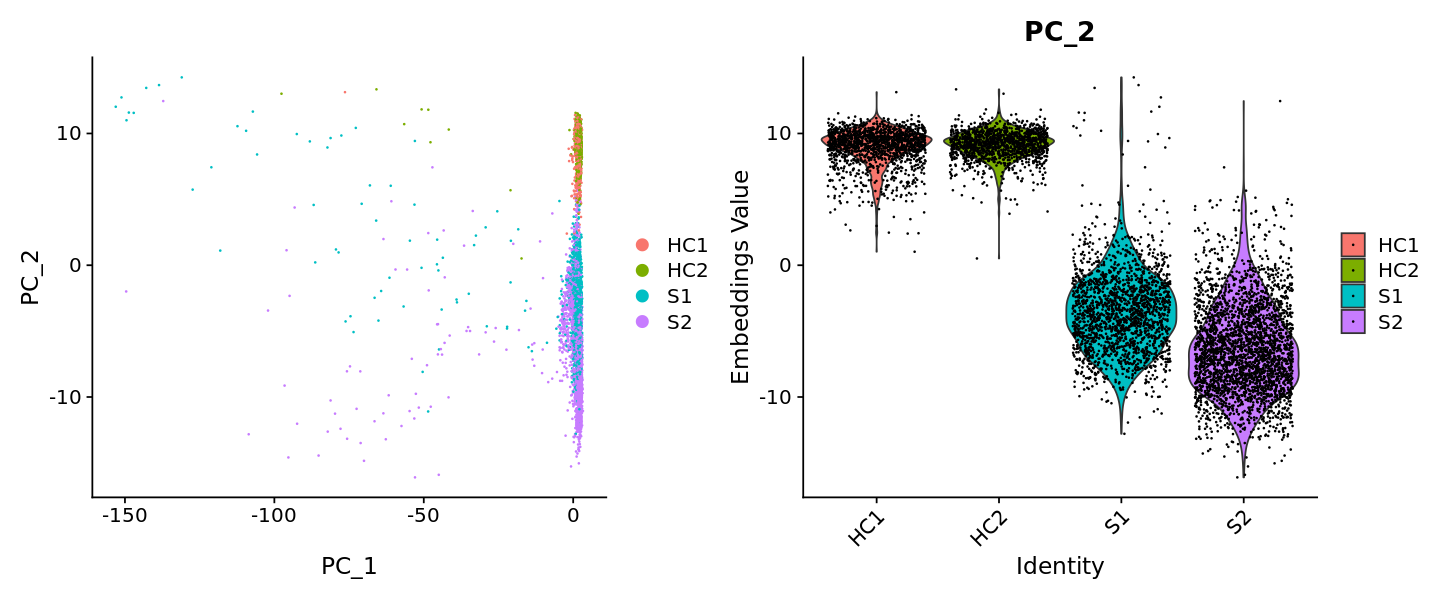

In [97]:
options(repr.plot.height = 5, repr.plot.width = 12)
p1 = DimPlot(object = combined_seurat, reduction = "pca", pt.size = .1, group.by = "orig.ident")
p2 = VlnPlot(object = combined_seurat, features = "PC_2", group.by = "orig.ident",pt.size = .1)
p1 + p2

Here we can see that there is a clear separation between HC1/2 and S1/2 in PC2. We can also spot a small difference between S1 and S2 runs. We will use each run as technical batch, in order to retain the biological difference between healthy and covid19 patients.  

The simplest way to run Harmony is to pass the Seurat object and specify which variable(s) to integrate out. RunHarmony returns a Seurat object, updated with the corrected Harmony coordinates. Let's set plot_convergence to TRUE, so we can make sure that the Harmony objective function gets better with each round.

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


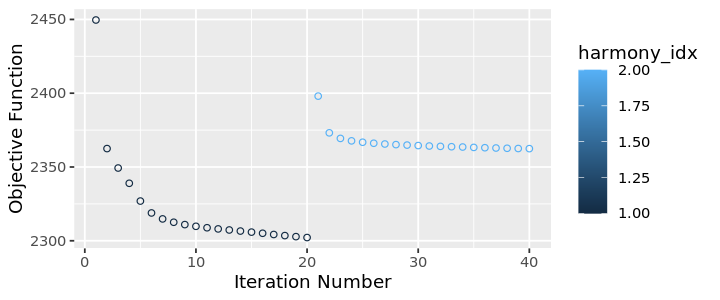

In [98]:
library(harmony)
options(repr.plot.height = 2.5, repr.plot.width = 6)
combined_seurat = combined_seurat %>% 
    RunHarmony("orig.ident", plot_convergence = TRUE)

To directly access the new Harmony embeddings, use the Embeddings command.

In [99]:
harmony_embeddings = Embeddings(combined_seurat, 'harmony')
harmony_embeddings[1:5, 1:5]

harmony_1 harmony_2 harmony_3  harmony_4   harmony_5 
S2_GTAGTCAGTGTCCTCT-1  1.2756200  1.622487 -10.851144 -0.07847696 -9.0918452
S1_GGGTTGCAGACACGAC-1  3.0814583 -8.114838   3.339935  1.53150305 -0.3261566
HC1_TACGGATTCCTAGGGC-1 1.3433264  6.667797   1.427219 -0.81226055  1.0706096
S2_CCAGCGACATGGTCTA-1  0.9612336 -1.046244   2.279017  0.02342821  1.5053544
S2_CCTTTCTAGCTTATCG-1  1.8010700 -3.960842   3.570298  1.41139580 -1.8404381

Let's make sure that the datasets are well integrated in the first 2 dimensions after Harmony.

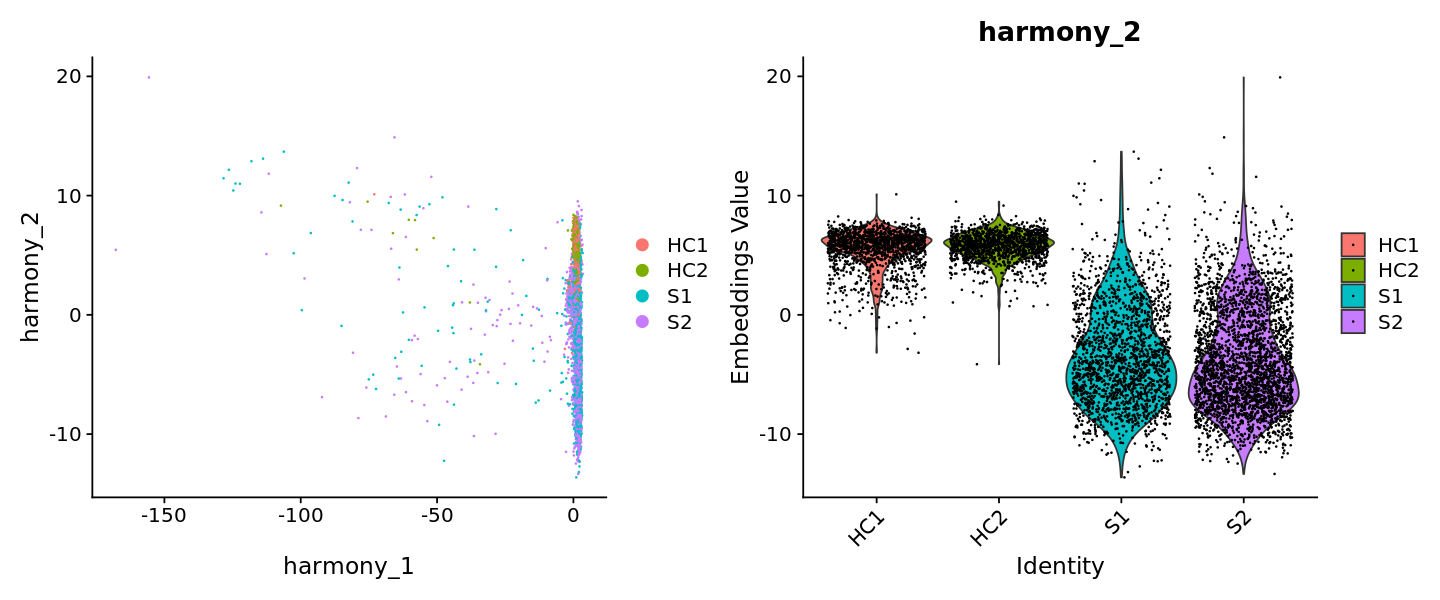

In [109]:
options(repr.plot.height = 5, repr.plot.width = 12)
p1 = DimPlot(object = combined_seurat, reduction = "harmony", pt.size = .1, group.by = "orig.ident")
p2 = VlnPlot(object = combined_seurat, features = "harmony_2", group.by = "orig.ident", pt.size = .1)
p1 + p2

Great, the difference between H1/2 and S1/2 in Harmony_2 embedding is less pronounced after running harmony batch correction. 

**Task**: Explore other Harmony embeddings to see their effect on the data. 

In [110]:
combined_seurat2 = combined_seurat %>% 
    RunUMAP(reduction = "harmony", dims = 1:20) %>% 
    FindNeighbors(reduction = "harmony", dims = 1:20) %>% 
    FindClusters(resolution = 0.5) %>% 
    identity()

19:02:48 UMAP embedding parameters a = 0.9922 b = 1.112

19:02:48 Read 7583 rows and found 20 numeric columns

19:02:48 Using Annoy for neighbor search, n_neighbors = 30

19:02:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

19:02:50 Writing NN index file to temp file /tmp/Rtmp8szWQL/file1b90611e3e7d

19:02:50 Searching Annoy index using 1 thread, search_k = 3000

19:02:52 Annoy recall = 100%

19:02:53 Commencing smooth kNN distance calibration using 1 thread

19:02:55 Initializing from normalized Laplacian + noise

19:02:55 Commencing optimization for 500 epochs, with 326124 positive edges

19:03:04 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7583
Number of edges: 276934

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8558
Number of communities: 11
Elapsed time: 0 seconds


**Task**: Let's visualise corrected cells using umap!

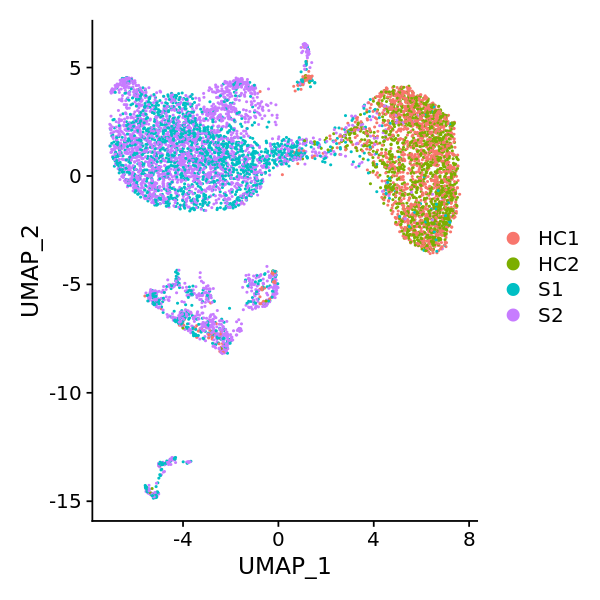

In [111]:
#Answer:
options(repr.plot.height = 5, repr.plot.width = 5)
DimPlot(combined_seurat2, reduction = "umap", group.by = "orig.ident")

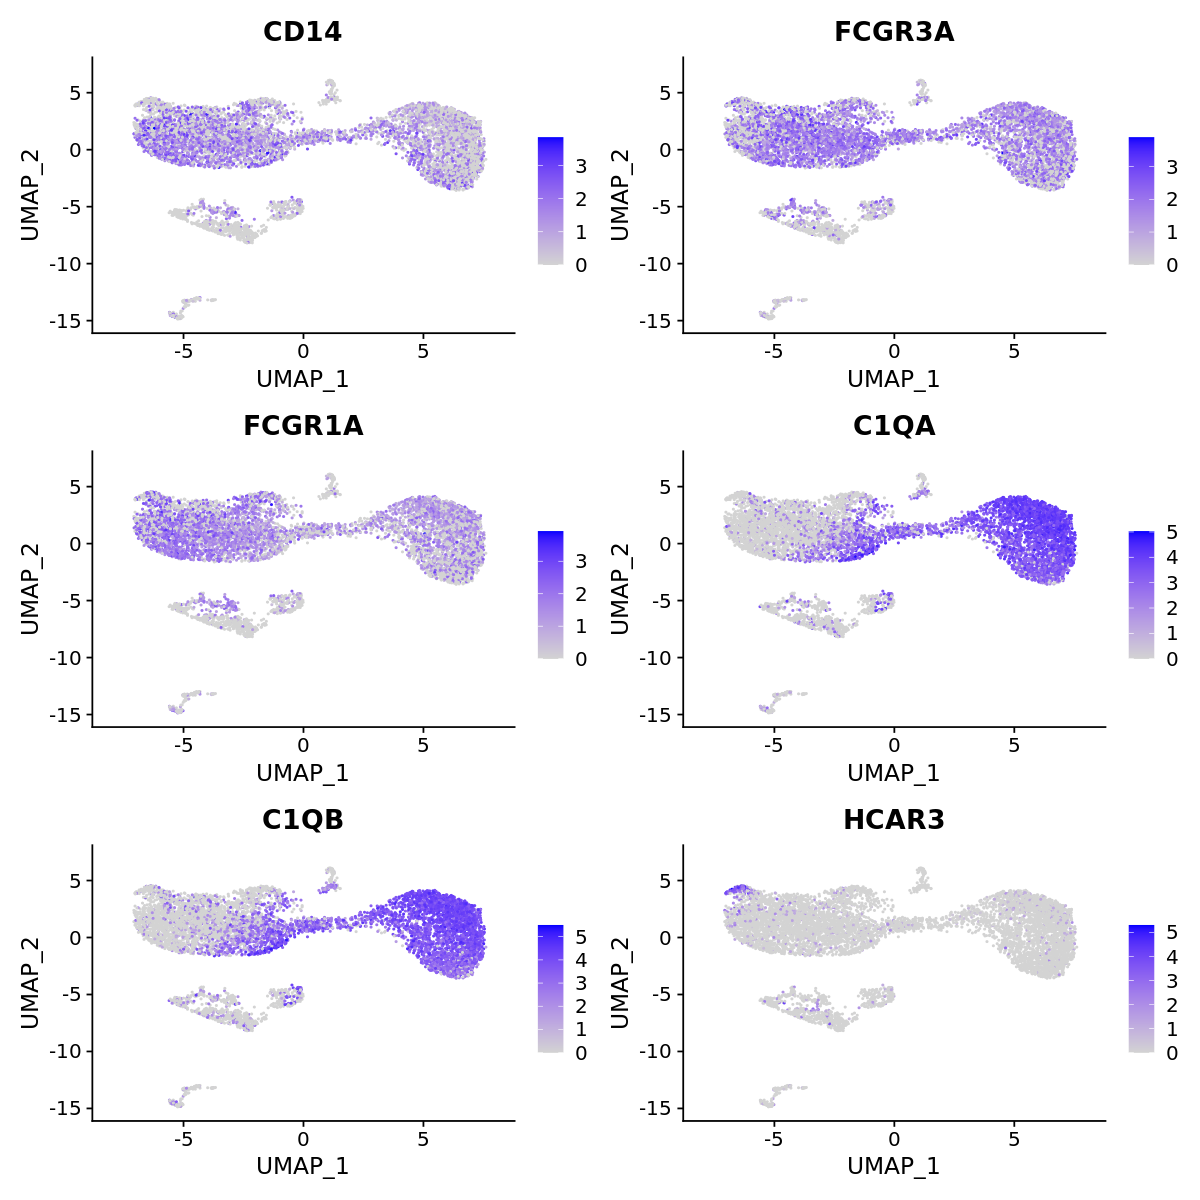

In [112]:
options(repr.plot.height = 10, repr.plot.width = 10)
FeaturePlot(combined_seurat2, c("CD14", "FCGR3A", "FCGR1A", "C1QA", "C1QB","HCAR3"))

In [169]:
combined_seurat2 = FindClusters(combined_seurat2, resolution = 0.8)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7583
Number of edges: 276934

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8212
Number of communities: 14
Elapsed time: 0 seconds


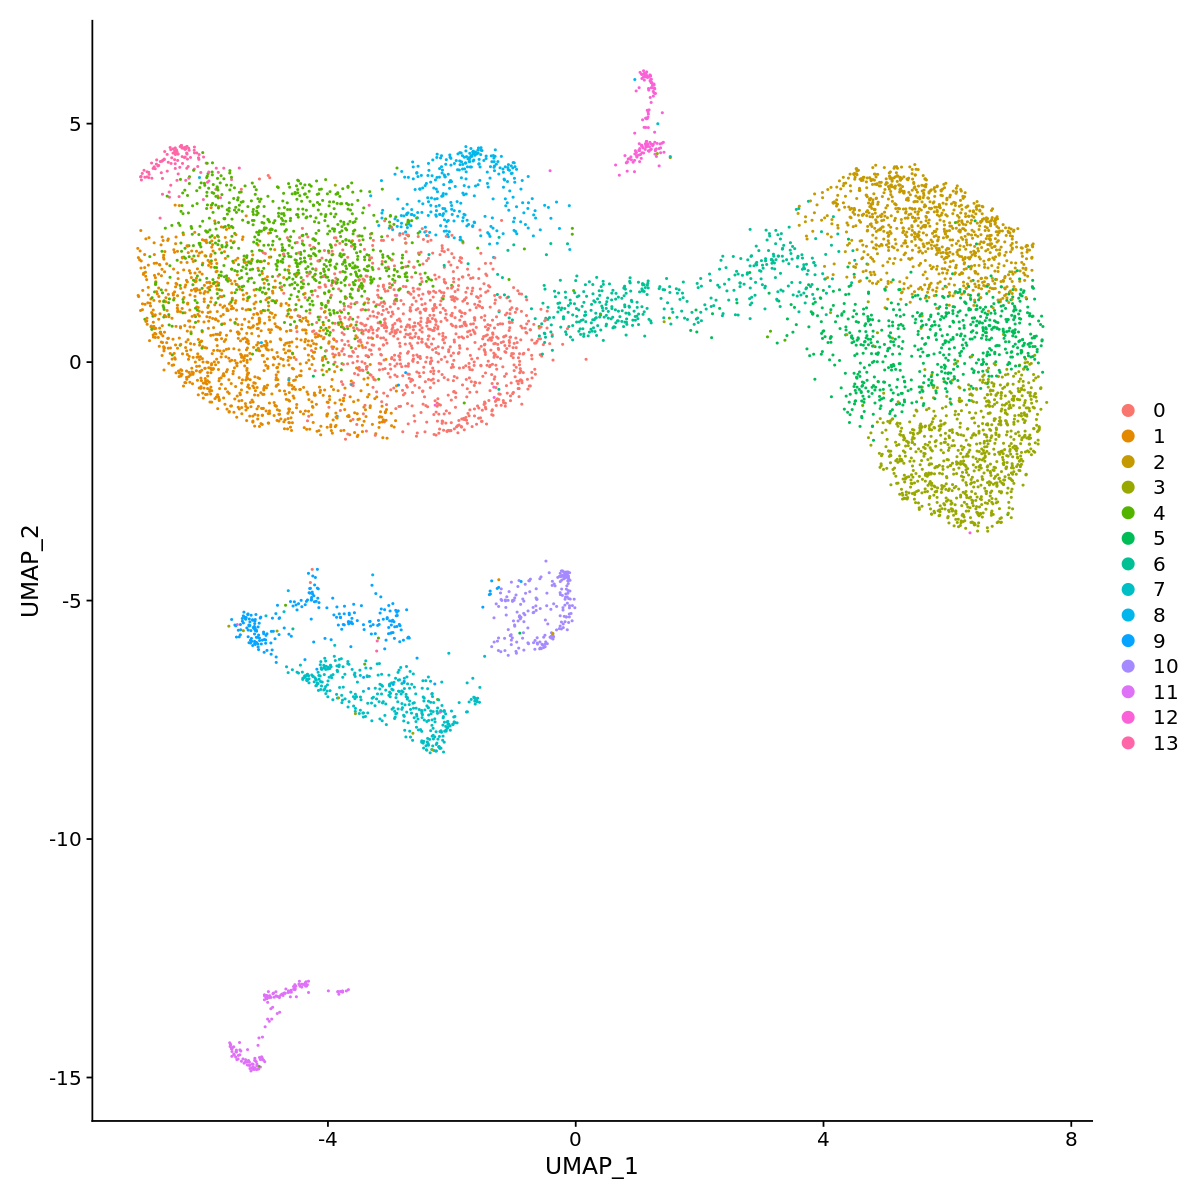

In [170]:
DimPlot(combined_seurat2, reduction = "umap")

There are still some differences between healthy (H1,H2) and COVID19 patient (S1,S2) macrophages, that may be related to the activation status of these cells. However, post batch correction, macrophage cells from different healthy or patient donors mix within cluster, suggesting that we have removed the donor or technical variability between cells.

**Additional tool**: Seurat 3. IMPORTANT DIFFERENCE: In the Seurat integration tutorial, you need to define a Seurat object for each dataset. With Harmony integration, only one Seurat object with all cells is required. 
https://satijalab.org/seurat/Seurat_AlignmentTutorial.html

**Additional tool**: http://bioconductor.org/packages/release/bioc/html/batchelor.html

Batch correction is a controversial subject, and some prefer to skip batch correction in order to avoid removing true biology. You can read more about ways to overcome batch in this blog post:  
https://constantamateur.github.io/2020-10-24-scBatch2/

## 4.3 Automated annotation

The number of scRNAseq datasets has grown exponentially in the last few years. There’s a good chance that a useful annotated dataset exists out there to help you annotate your own data. In addition to greatly reducing the amount of time it takes to annotate the dataset, it also avoid the bias that comes with manual marker picking as we did above. We will use two independent automated prediction tools - TransferData from Seurat and logistic regression from Young et al. 2018.

In logistic regression (specifically, one-versus rest binomial logistic regression), you train a model on your (annotated) reference data, and use that model to predict the similarity of each cell type to each cell in the query dataset.The biggest advantage of logistic regression is that it naturally allows for a target population to match nothing in the reference, without the need for ad-hoc cut-offs for “this doesn’t match particularly well”. However, the annotation needs to be sufficiently distinct (i.e. logistic regression might do poorly if different categories in the reference dataset are too similar). It will also work poorly, or not not at all, for clusters with fewer than 10 cells (in the annotation).

We will load our reference - in this case, we will be using an annotated version of the same dataset we’ve been working on just to showcase how the method works. This particular logistic regression model isn’t in an R package, so we have to load in the script with the functions as well.

In [116]:
source("/mnt/sc_train_course/logisticRegression.R")
reference=readRDS("/mnt/sc_train_course/reference.rds")

Loading required package: ComplexHeatmap

ComplexHeatmap not found.  This library is needed for plotting functions.  It's the best heatmap library, so install it anyway :)



We train the model on the reference, providing the count matrix and the annotation.

In [117]:
tr_lung=trainModel(reference@assays$RNA@counts, reference@meta.data$annot, workers=NULL)

Sub-sampled from 7491 entries to 2002

Fitting model for variable Mast

Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message:
“from glmnet Fortran code (error code -2); Convergence fo

We then predict the similarity to query dataset, providing the trained model, query dataset count matrix and cluster identities.

In [139]:
workers=NULL
pr_lung=predictSimilarity(tr_lung, combined_seurat2@assays$RNA@counts, combined_seurat2$seurat_clusters)

We can then visualise:

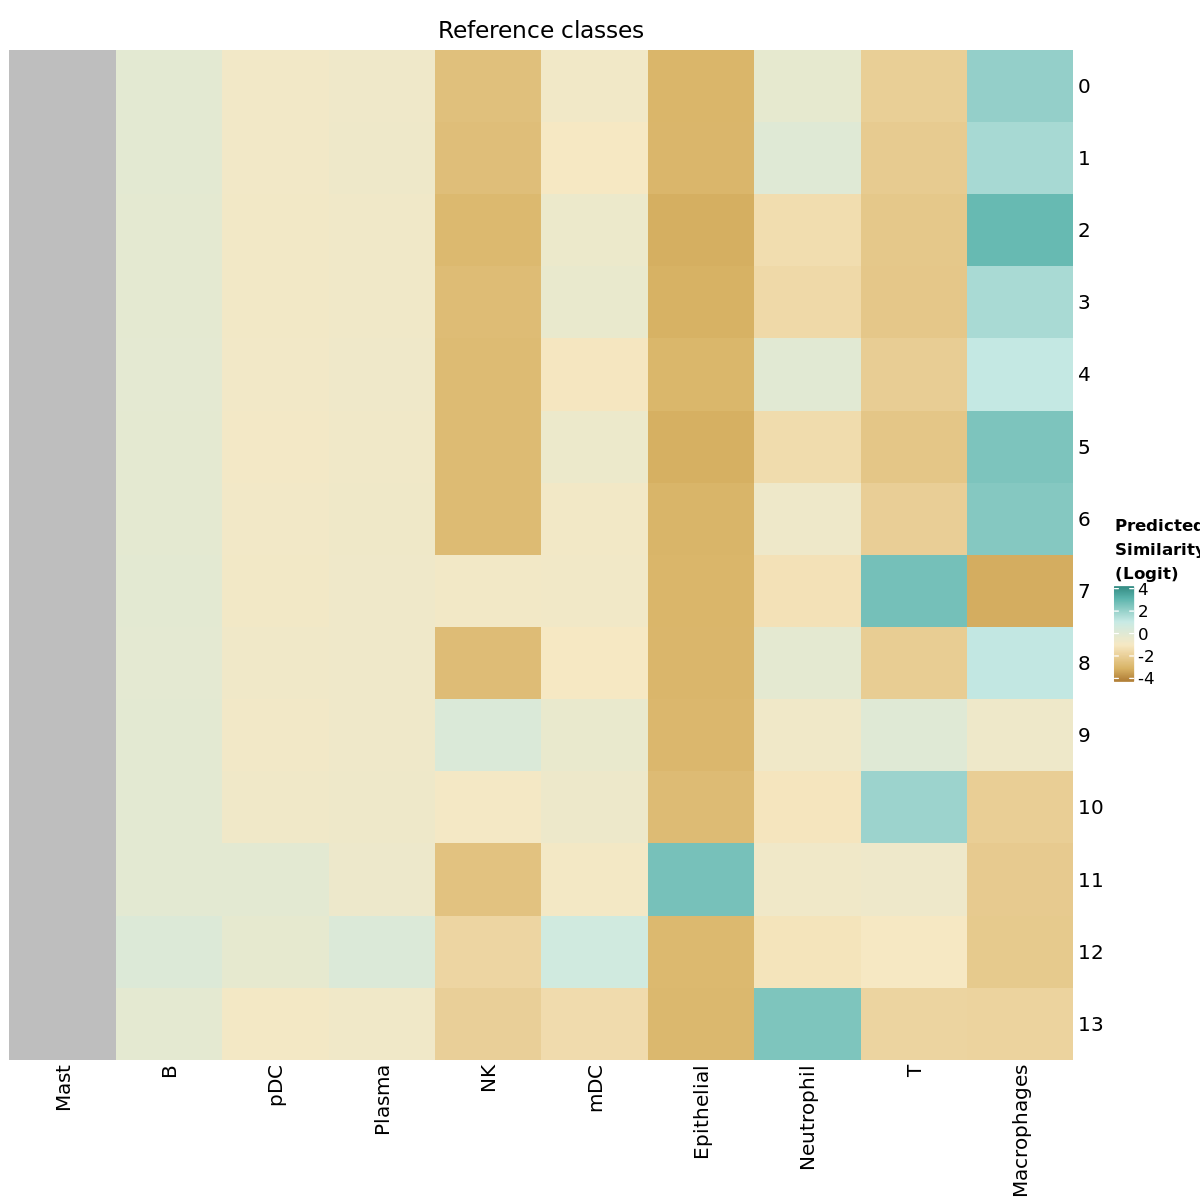

In [140]:
similarityHeatmap(pr_lung)

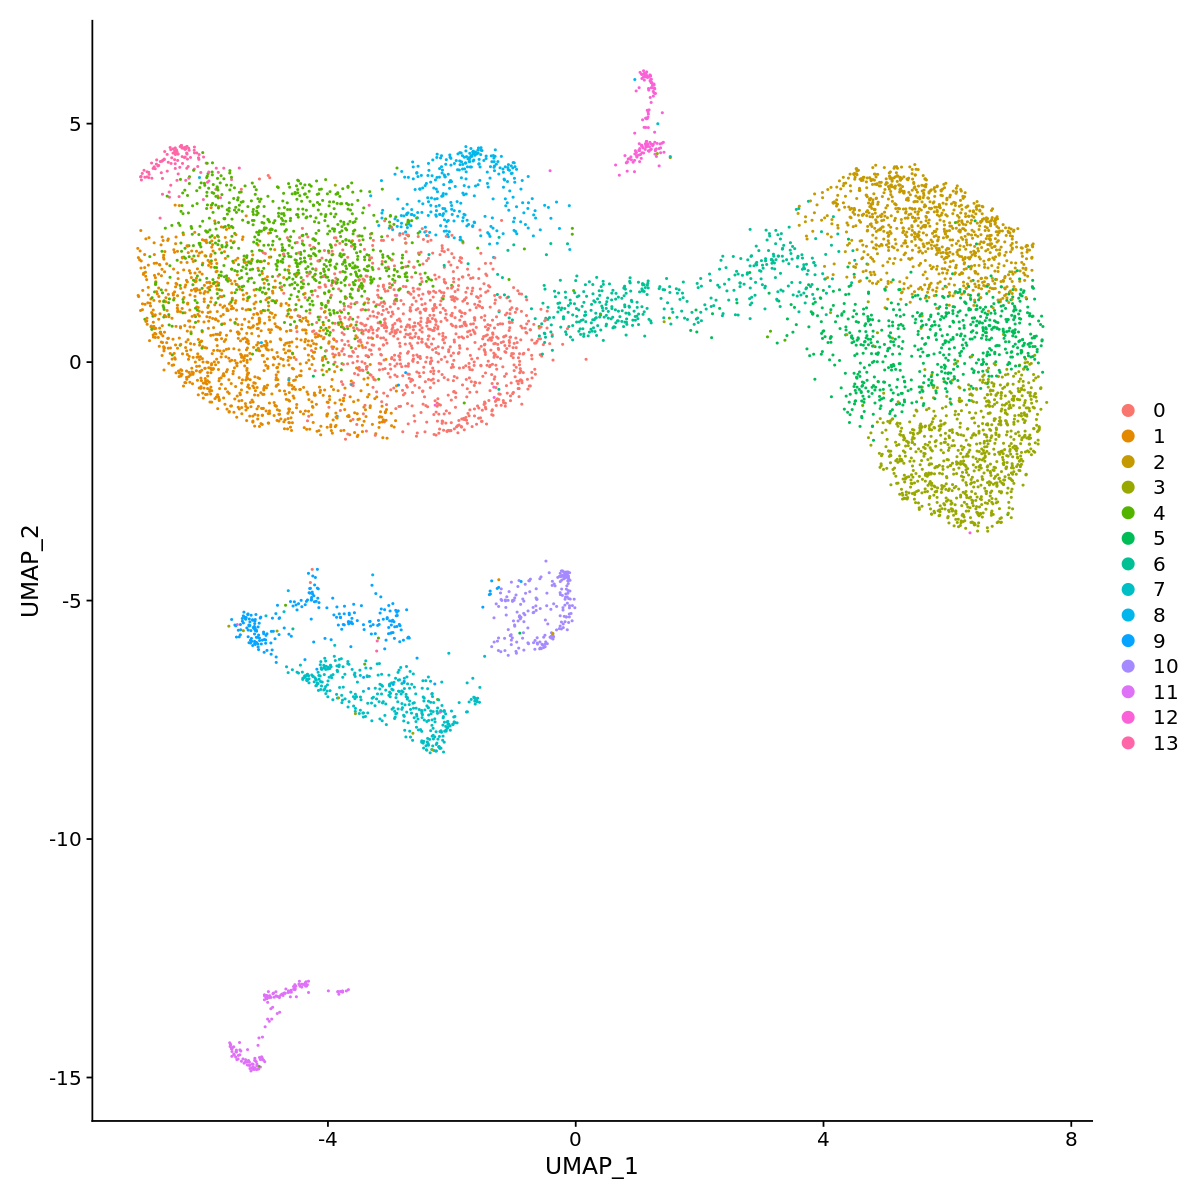

In [141]:
DimPlot(combined_seurat2, reduction = "umap")

**Task**: Which clusters resemble marcrophages? Are they the same ones we defined as macrophages based on marker analysis?

Mast cell column is grey - this is because there were too few cells in that category to calculate the coefficients. The signal in B and pDC is not well-defined - this is because there were very few cells in each of those categories.

Let’s try a different method - TransferData. This is a canonical correlation analysis method - essentially, it measures how well correlated the expression values are in between cells in the reference and cells in the query datasets. This method involves finding the “anchors”, which represent pairwise correspondences between individual cells (one in each dataset) that should originate from the same biological state. These ‘anchors’ are then used to harmonize the datasets, or transfer information from one dataset to another.

In [142]:
dat.anchors = FindTransferAnchors(reference = reference, query = combined_seurat2, 
    dims = 1:30)
predictions = TransferData(anchorset = dat.anchors, refdata = reference@meta.data$annot, 
    dims = 1:30)
combined_seurat2 = AddMetaData(combined_seurat2, metadata = predictions)

Performing PCA on the provided reference using 2000 features as input.

Projecting PCA

Finding neighborhoods

Finding anchors

	Found 19221 anchors

Filtering anchors

	Retained 14254 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



Let’s plot the prediction scores for a few of the query cell types:

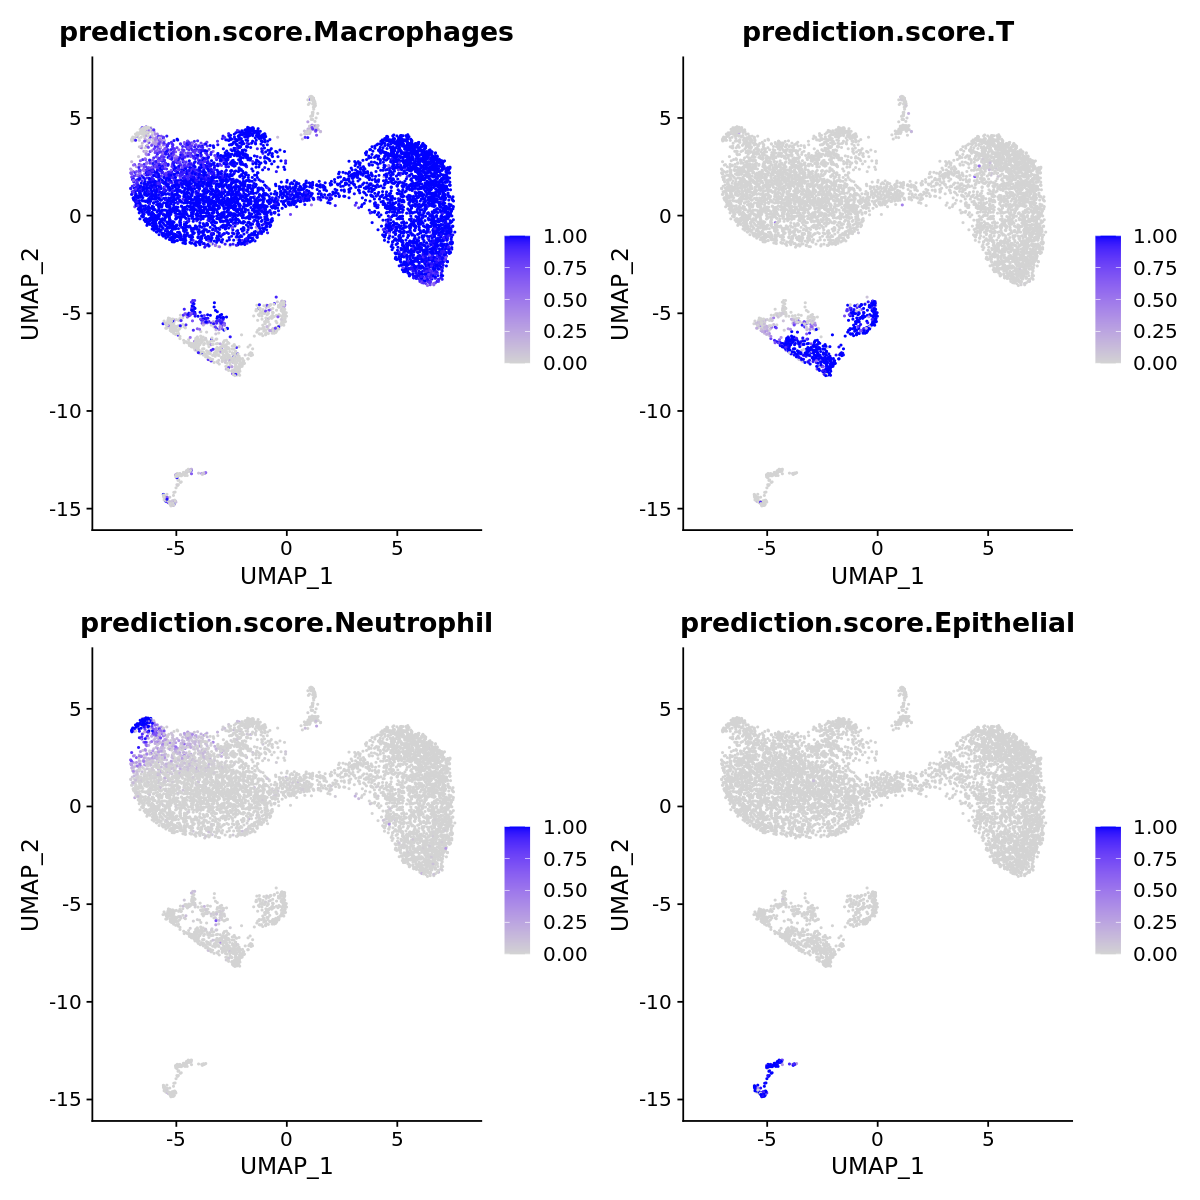

In [143]:
FeaturePlot(combined_seurat2, c("prediction.score.Macrophages","prediction.score.T",
                                "prediction.score.Neutrophil","prediction.score.Epithelial"))

**Task**: Have a look at the prediction scores for the remaining cell types in the reference.

We will now produce a final annotation of our data and find algorithmic markers associated for each cell type by assigning cell types to our clusters.

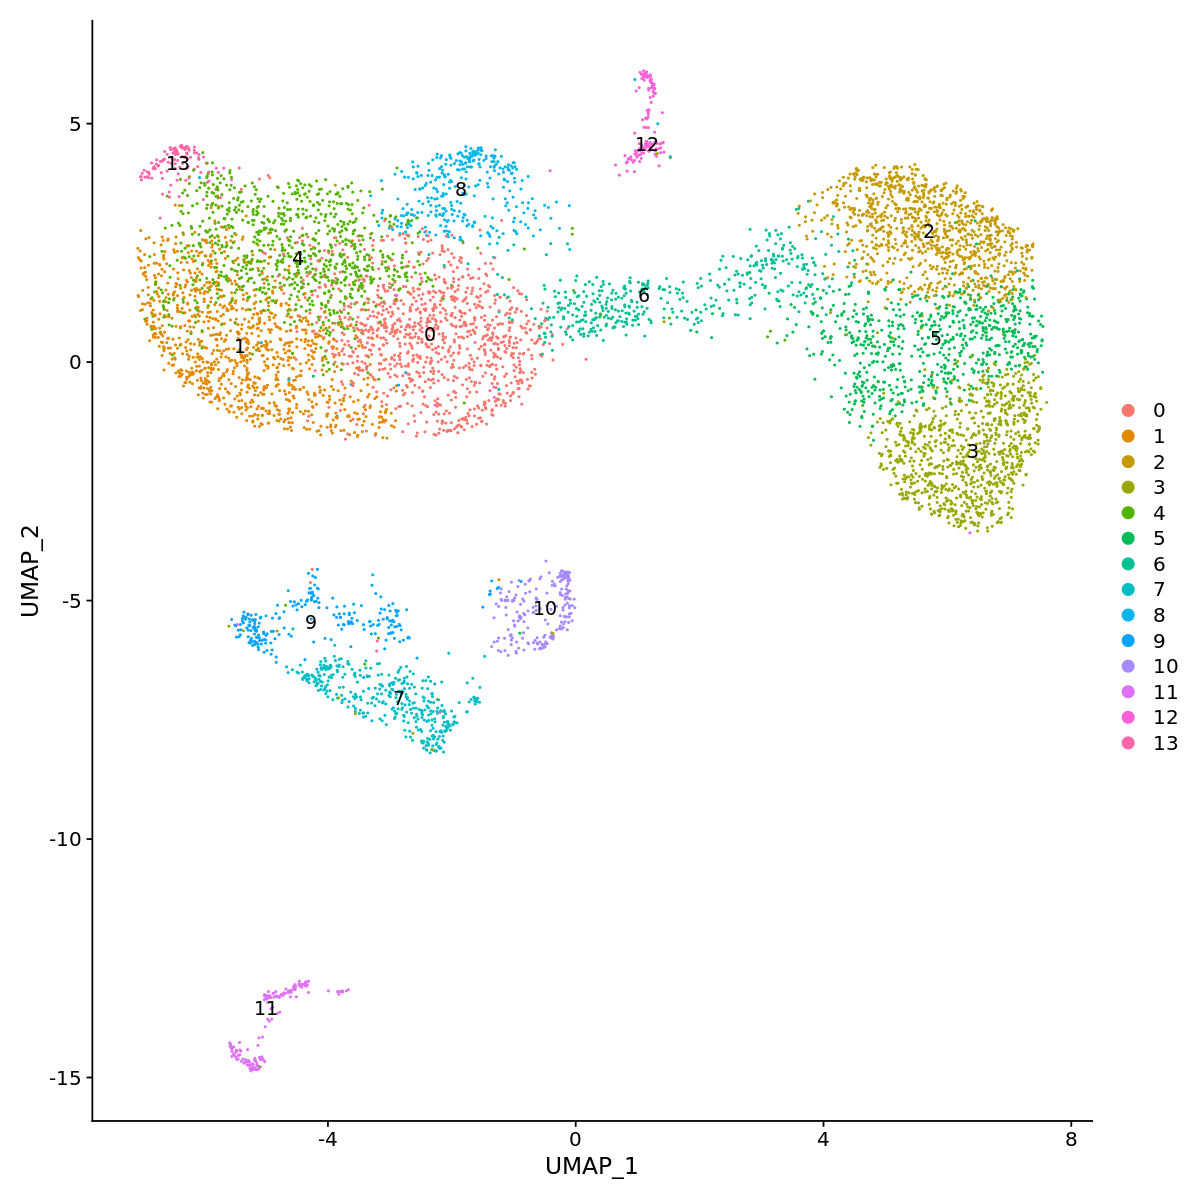

In [171]:
DimPlot(combined_seurat2, reduction = "umap", label=TRUE)

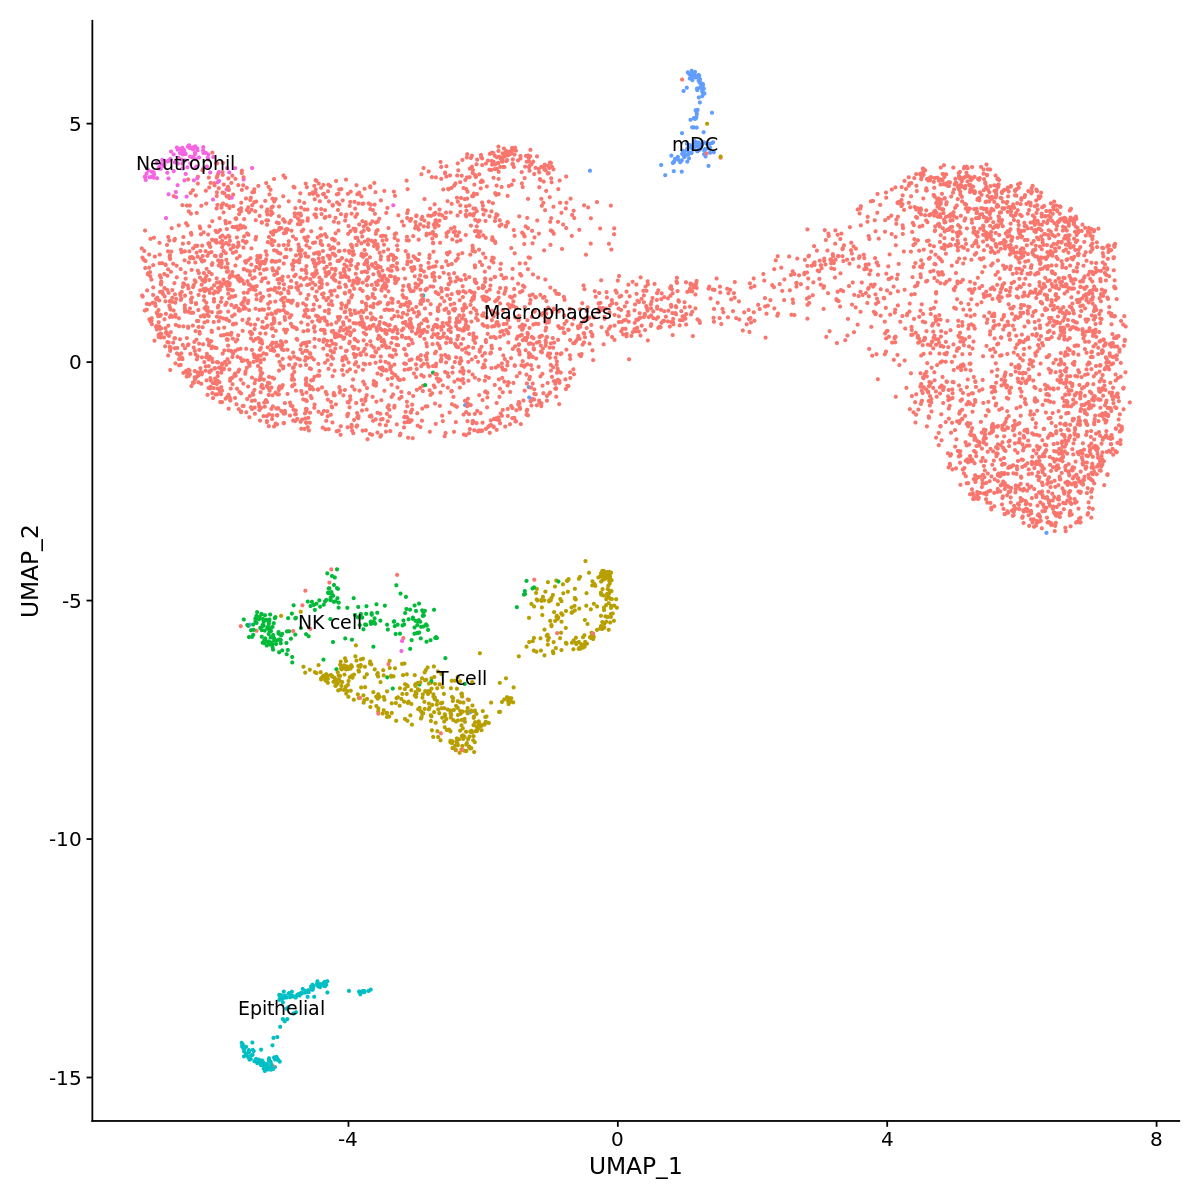

In [172]:
new.cluster.ids = c("Macrophages", "Macrophages", "Macrophages", "Macrophages", "Macrophages",
                    "Macrophages", "Macrophages","T cell", "Macrophages", "NK cell","T cell","Epithelial",
                    "mDC","Neutrophil")
names(new.cluster.ids) = levels(combined_seurat2)
combined_seurat2 = RenameIdents(combined_seurat2, new.cluster.ids)
DimPlot(combined_seurat2, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In this scRNA-seq experiment, the authors also captured viral RNA. This is stored as gene 
"nCoV". 

**Task**: Can you plot SARS-COV2 viral RNA expression on a umap? Which cell type does the virus infect? 

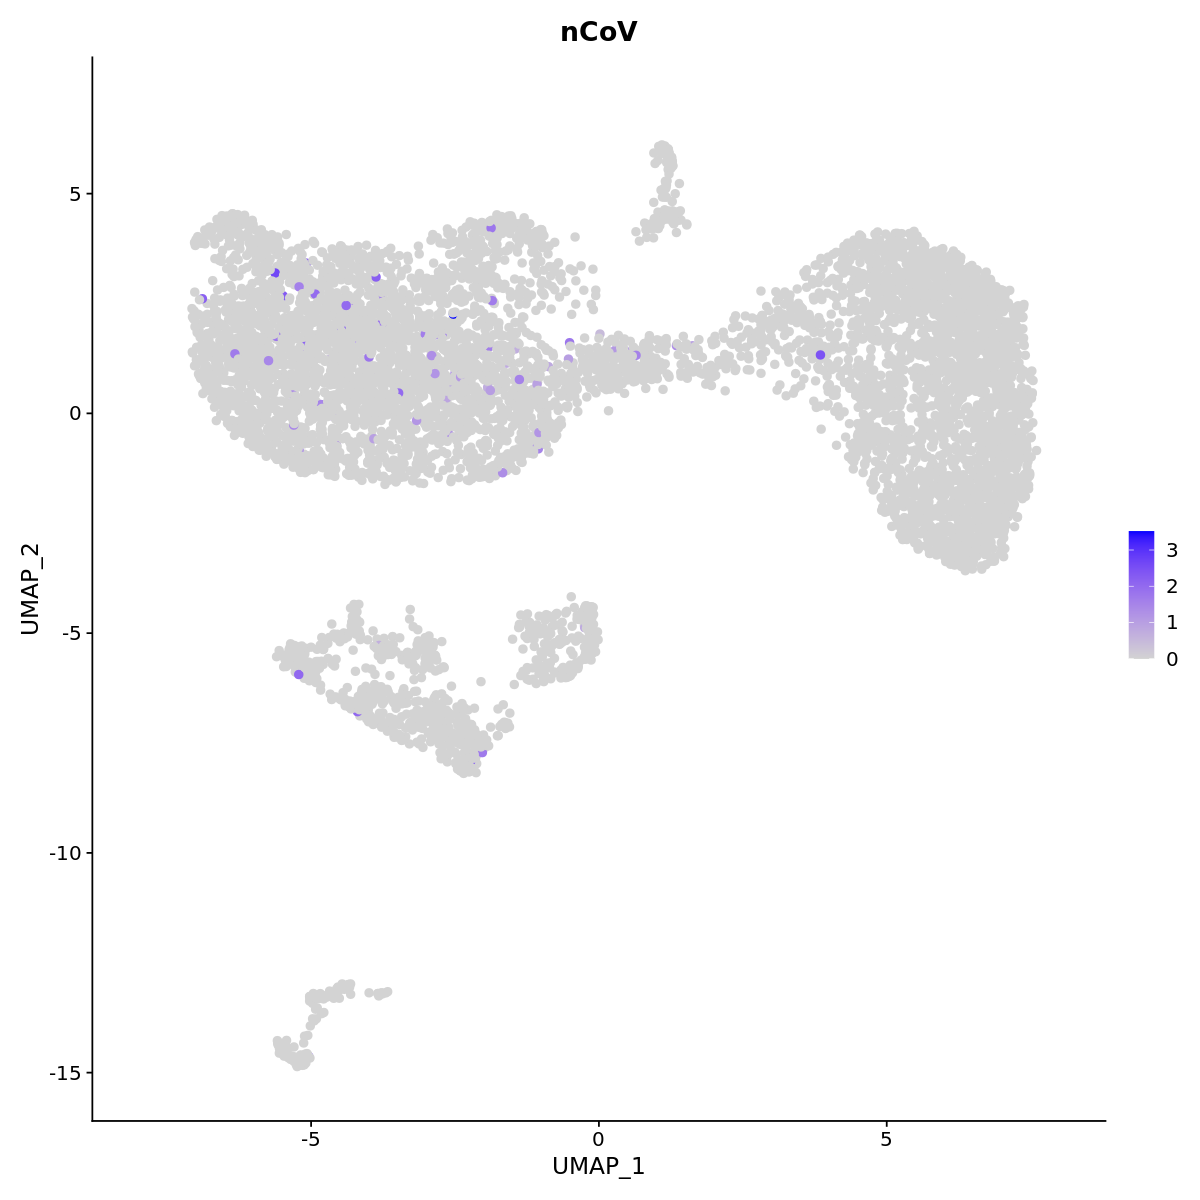

In [163]:
FeaturePlot(combined_seurat2, c("nCoV"), pt.size=2)

Let’s also produce a list of differentially expressed genes between HC and S macrophages. You will use these gene list in Day3. 

In [ ]:
code for diff

## 4.4 SoupX

All droplet based single cell RNA-seq experiments also capture ambient mRNAs present in the input solution along with cell specific mRNAs of interest. This contamination is ubiquitous and can vary hugely between experiments (2% - 50%), although around 10% seems reasonably common. SoupX is an R package for the estimation and removal of cell free mRNA contamination in droplet based single cell RNA-seq data. Correcting for this contamination improves biological interpretation of the data.

SoupX (or any other tool designed to remove cell free mRNA) should be run per sample/10X channel, and requires both raw and filtered matrices - we can’t run it on our practical sample as we only have filtered matrices for data. We will use a toy example where both raw and filtered matrices are available and follow the (shortened) tutorial in SoupX vignette.

We will use 10X PBMC data sets to demonstrate how to use this package. The starting point is to download the raw and filtered cellranger output and extract them to a temporary folder as follows.

In [146]:
tmpDir = tempdir(check = TRUE)
download.file("https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc4k/pbmc4k_raw_gene_bc_matrices.tar.gz", 
    destfile = file.path(tmpDir, "tod.tar.gz"))

In [147]:
download.file("https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc4k/pbmc4k_filtered_gene_bc_matrices.tar.gz", 
    destfile = file.path(tmpDir, "toc.tar.gz"))


In [148]:
untar(file.path(tmpDir, "tod.tar.gz"), exdir = tmpDir)
untar(file.path(tmpDir, "toc.tar.gz"), exdir = tmpDir)

SoupX comes witha function to laod in the data, which also automatically estimates profiles the Soup:

In [149]:
sc = load10X(tmpDir)

Loading raw count data

Loading cell-only count data

Loading extra analysis data where available



To avoid downloading or including large data files, this vignette will use a pre-loaded and processed object PBMC_sc.

In [150]:
data(PBMC_sc)
sc = PBMC_sc
sc

Channel with 33694 genes and 2170 cells



We have some extra meta data that it is essential we include in our SoupChannel object. There are some bits of meta data that are so essential that they have their own special loading functions. The most essential is clustering information. Without it, SoupX will still work, but you won’t be able to automatically estimate the contamination fraction and the correction step will be far less effective. Metadata associated with our PBMC dataset is also bundled with SoupX. We can use it to add clustering data by running,

In [151]:
data(PBMC_metaData)
sc = setClusters(sc, setNames(PBMC_metaData$Cluster, rownames(PBMC_metaData)))

It can also be very useful to be able to visualise our data by providing some kind of dimension reduction for the data. We can do this by running:

In [152]:
sc = setDR(sc, PBMC_metaData[colnames(sc$toc), c("RD1", "RD2")])

It is often the case that really what you want is to get a rough sense of whether the expression of a gene (or group of genes) in a set of cells is derived from the soup or not. At this stage we already have enough information to do just this. Before proceeding, we will briefly discuss how to do this.

Let’s start by getting a general overview of our PBMC data by plotting it with the provided annotation.

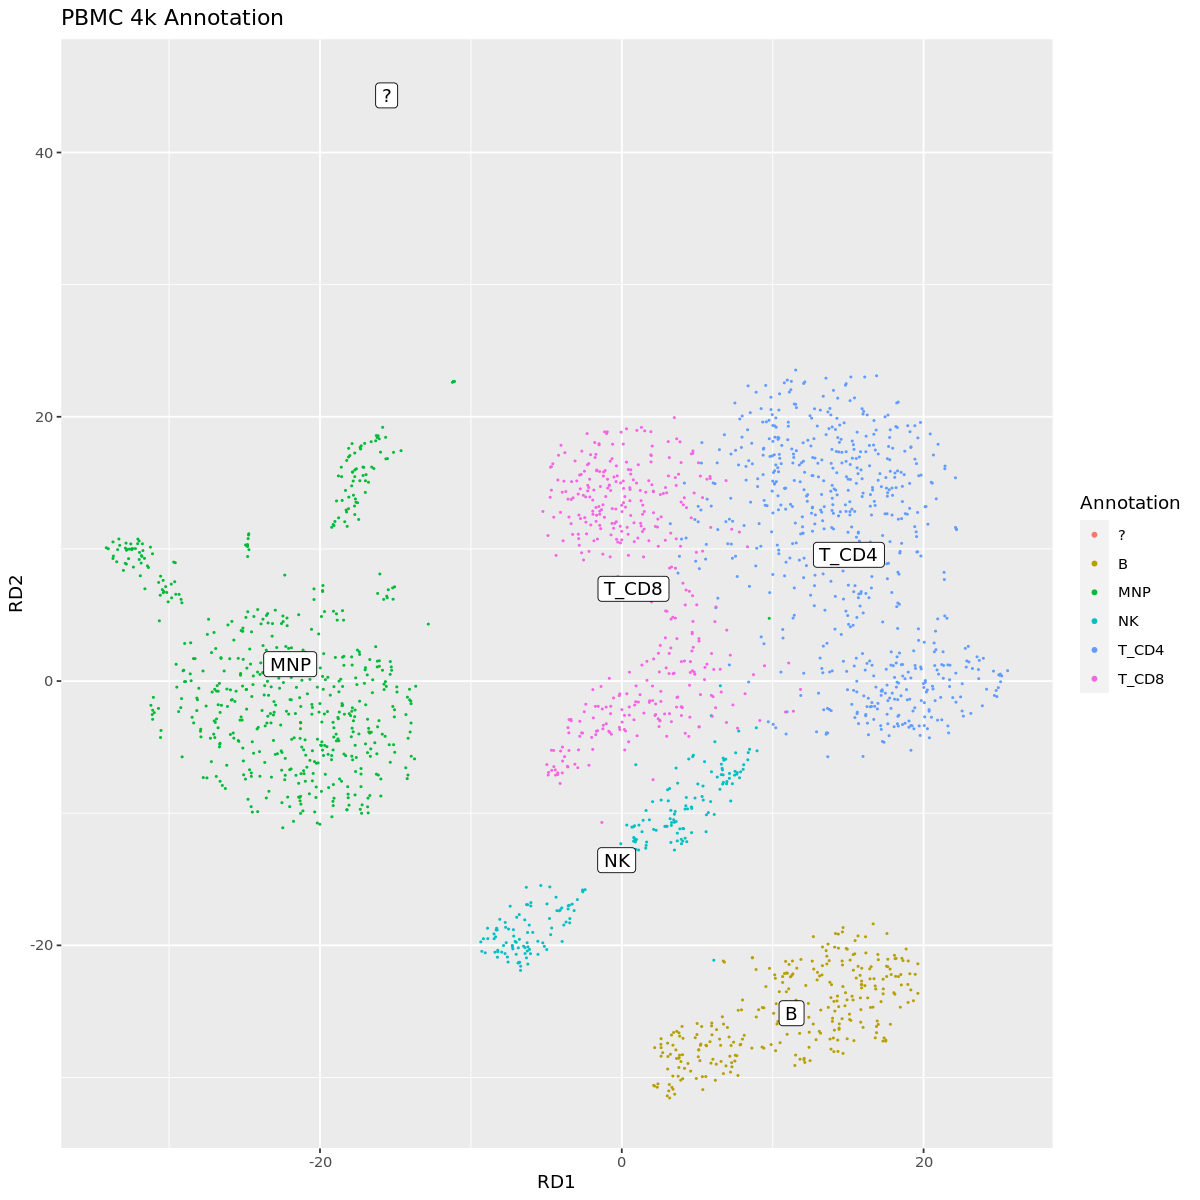

In [153]:
library(ggplot2)
dd = PBMC_metaData[colnames(sc$toc), ]
mids = aggregate(cbind(RD1, RD2) ~ Annotation, data = dd, FUN = mean)
gg = ggplot(dd, aes(RD1, RD2)) + geom_point(aes(colour = Annotation), size = 0.2) + 
    geom_label(data = mids, aes(label = Annotation)) + ggtitle("PBMC 4k Annotation") + 
    guides(colour = guide_legend(override.aes = list(size = 1)))
plot(gg)

SoupX does not have any of its own functions for generating tSNE (or any other reduced dimension) co-ordinates, so it is up to us to generate them using something else. In this case I have run Seurat in a standard way and produced a tSNE map of the data (see ?PBMC).

Suppose that we are interested in the expression of the gene IGKC, a key component immunoglobulins (i.e., antibodies) highly expressed by B-cells. We can quickly visualise which cells express IGKC by extracting the counts for it from the SoupChannel object.

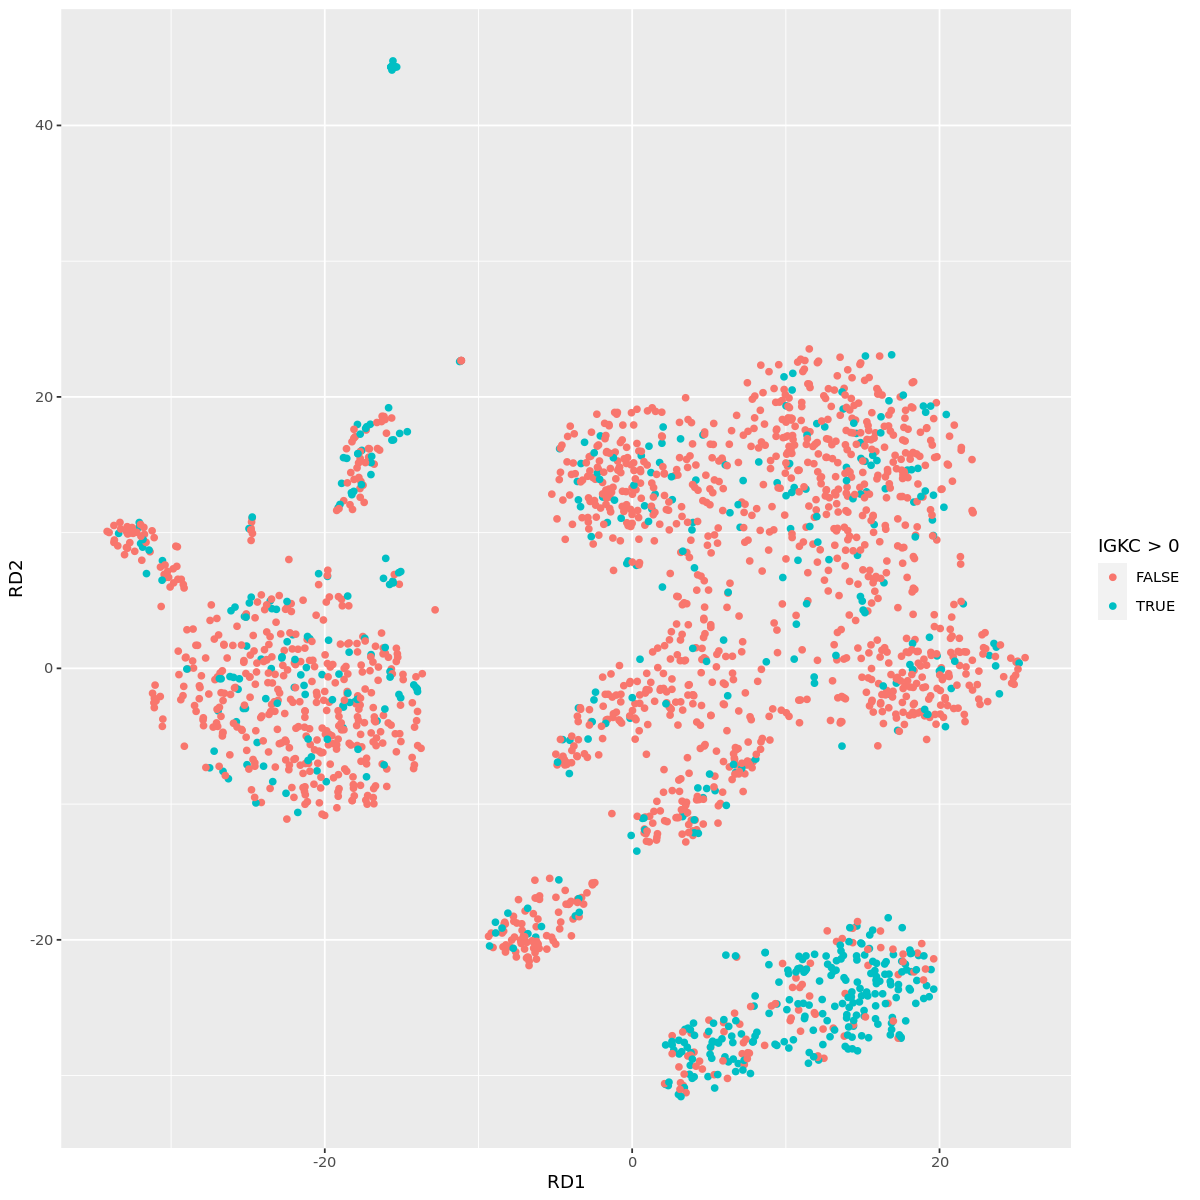

In [154]:
dd$IGKC = sc$toc["IGKC", ]
gg = ggplot(dd, aes(RD1, RD2)) + geom_point(aes(colour = IGKC > 0))
plot(gg)

Wow! We know from prior annotation that the cells in the cluster at the bottom are B-cells so should express IGKC. But the cluster on the right is a T-cell population. Taken at face value, we appear to have identified a scattered population of T-cells that are producing antibodies! Start preparing the nature paper!

Before we get too carried away though, perhaps it’s worth checking if the expression of IGKC in these scattered cells is more than we would expect by chance from the soup. To really answer this properly, we need to know how much contamination is present in each cell, which will be the focus of the next sections.

We can next estimate the contamination fraction using the automated method:

786 genes passed tf-idf cut-off and 401 soup quantile filter.  Taking the top 100.

Using 854 independent estimates of rho.

Estimated global rho of 0.06



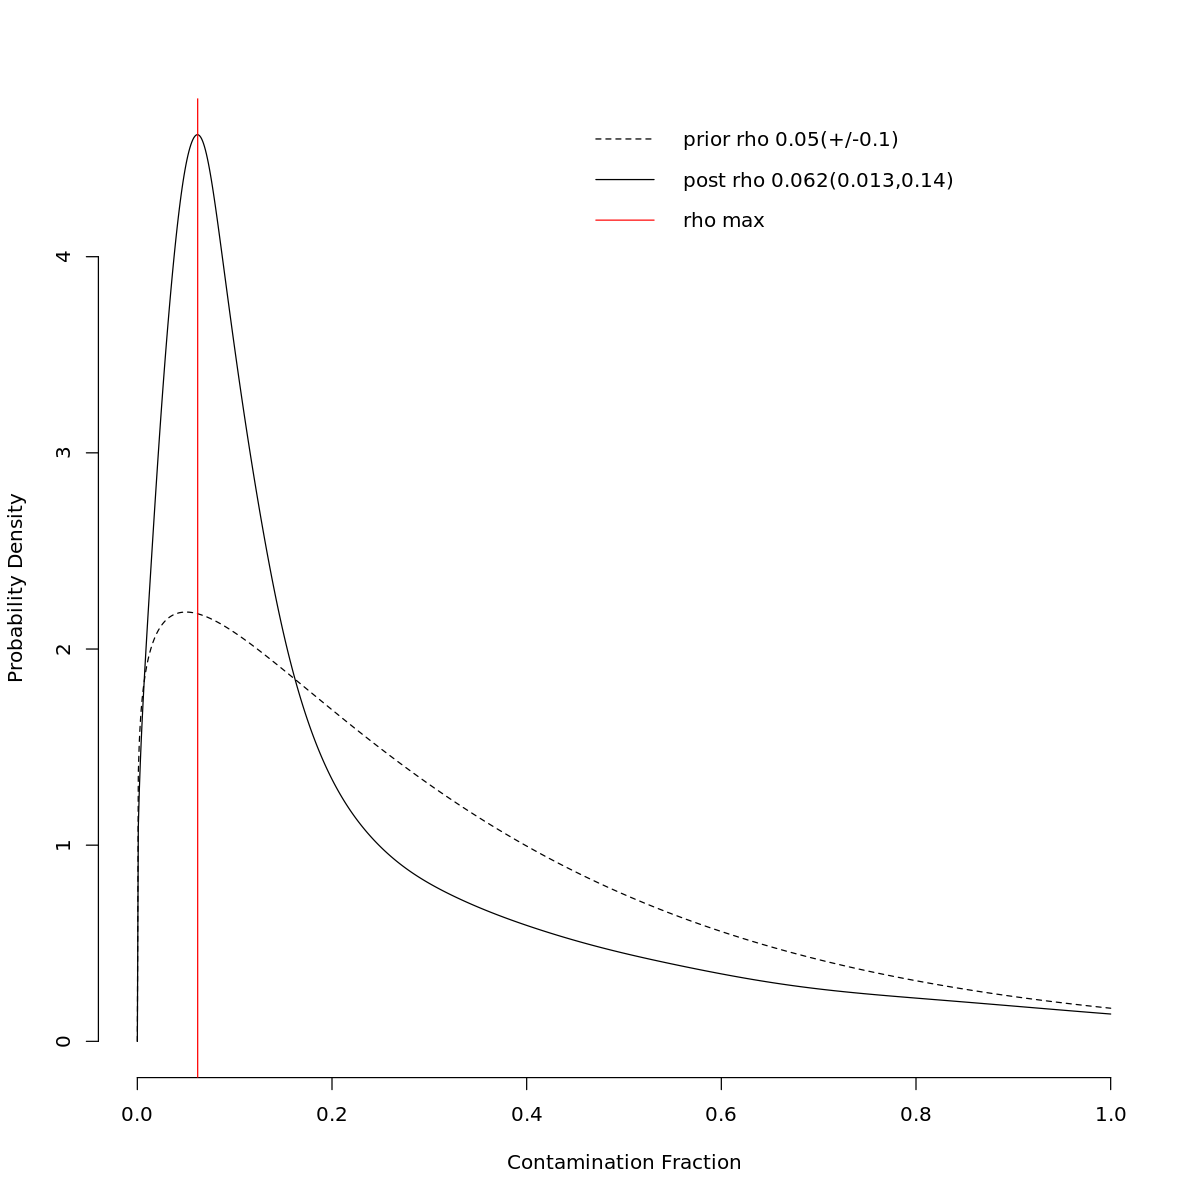

In [155]:
sc = autoEstCont(sc)

We can now adjust our counts given the estimated contamination fraction.

In [156]:
out = adjustCounts(sc)

Expanding counts from 12 clusters to 2170 cells.



Of course, the next thing you'll want to do is to load this corrected expression matrix into some downstream analysis tool and further analyse the data.
The corrected matrix can then be used for any downstream analysis in place of the uncorrected raw matrix. If you are using 10X data and would like to save these final counts out in the same format, you can use the DropletUtils write10xCounts function like this,

In [ ]:
#You don't have to run this. 
#DropletUtils:::write10xCounts("./strainedCounts", out)

# 5. Prepare data for ligand-receptor analysis using CellphoneDB

There are many online tools that require different scRNA-seq inputs for analysis. Therefore, it is important to know how to manipulate the Seurat object to extract data required to run a specific tool. 

Here we show how to prepare input files for CellphoneDB- a publicly available repository of curated receptors, ligands and their interactions (https://www.cellphonedb.org/). It can be used to search for a particular ligand/receptor or interrogate your own single-cell transcriptomics data. You will analyse the output of CellphoneDB tool in Day 3. 

The input files required are: 

- COUNTS file: scRNAseq count data containing gene expression values where rows are genes with Ensembl IDs and columns are cells. We recommend using normalised counts. Format accepted: .csv (comma separated) or .txt, .tsv, .tab.

- META file: Cell type annotation. Format accepted: .csv (comma separated) or .txt, .tsv, .tab (tab separated).


**Task**:  Can you identify where the relevant counts are stored in Seurat object? 

In [158]:
count_raw = combined_seurat2@assays$RNA@counts
count_norm = apply(count_raw, 2, function(x) (x/sum(x))*10000)

The final “gene” in our matrix is nCOV RNA, which is not a part of the standard 10X dataset, so we remove it:

In [159]:
count_norm=count_norm[1:33538,]

Next, we’ll convert gene symbols to ENSEMBL IDs and save our matrix:

In [165]:
#file that contains both gene symbols and ENSEMBL IDs
genes_10x = read.table("/mnt/sc_train_course/features.tsv", sep = "\t", header = F)
rownames(count_norm)=genes_10x$V1
write.table(count_norm, '/mnt/sc_train_course/cellphonedb_count.txt', sep='\t', quote=F)

Let’s create and save a metadata file that contains the annotation.

In [180]:
meta_data = cbind(rownames(combined_seurat2@meta.data), as.character(combined_seurat2@active.ident))
write.table(meta_data, '/mnt/sc_train_course/cellphonedb_meta.txt', sep='\t', quote=F, row.names=F)

In [179]:
head(meta_data)

[,1]                   [,2]       
[1,] S2_GTAGTCAGTGTCCTCT-1  T cell     
[2,] S1_GGGTTGCAGACACGAC-1  Macrophages
[3,] HC1_TACGGATTCCTAGGGC-1 Macrophages
[4,] S2_CCAGCGACATGGTCTA-1  Macrophages
[5,] S2_CCTTTCTAGCTTATCG-1  Neutrophil 
[6,] HC2_GACACGCGTCCAAGTT-1 Macrophages

You will use the cellphonedb_count and cellphonedb_meta files for your next practical.

In [181]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ComplexHeatmap_2.2.0        glmnet_4.0-2               
 [3] SoupX_1.4.5                 ggplot2_3.3.2              
 [5] harmony_1.0                 Rcpp_1.0.5                 
 [7] patchwork_1.0.1             DropletUtils_1.6.1         
 [9] SingleCellExperiment_1.8.0  SummarizedExp

**THE END**

**Acknowledgments:** 
https://broadinstitute.github.io/2019_scWorkshop
https://github.com/jepark87/single_cell_analysis/blob/master/EBI_single_cell_course/filter_and_batch_correction_tutorial.md
http://htmlpreview.github.io/?https://github.com/immunogenomics/harmony/blob/master/docs/SeuratV3.html
https://rawcdn.githack.com/constantAmateur/SoupX/6be48cdb0950ed145a3ca6cf235ec2c24d626f81/inst/doc/pbmcTutorial.html